In [185]:
# %pip install spacy
# %pip install spacy-transformers
# %pip install --upgrade huggingface-hub
# from spacy.cli import download
# download("en_core_web_trf")

# from spacy.cli import download
# download("en_core_web_sm")

In [186]:
import os
from pathlib import Path

dir = Path.cwd()

# Spacy Extraction

## Social Referent

In [187]:
import pandas as pd
import spacy
import re

# Used the spacy model with higher accuracy trf
# Use sm for smaller sample size exhibition
nlp = spacy.load("en_core_web_trf")
STOP = ["&", "xxx", "=", "_", "zorg", "mm-hm", "[", "]", ":", "CHI:"]


# Function to clean text and referent
def clean_text(text):
    escaped_stop = [re.escape(s) for s in STOP]
    pattern = "|".join(escaped_stop)
    cleaned_text = re.sub(pattern, "", text)
    return cleaned_text


def clean_referent(referent):
    cleaned_referent = re.sub(r"\s*\([ABab]\)\s*", "", referent)
    return cleaned_referent.strip()


# Function to extract adjectives using SpaCy
def extract_adjectives(text):
    doc = nlp(text)
    adj_list = [token.text for token in doc if token.pos_ == "ADJ"]
    return adj_list if adj_list else pd.NA

In [188]:
# Social Master Sheet
df = pd.read_csv(
    dir.parent
    / "Data"
    / "Master Children Description Data - Master Social description.csv"
)

# Clean the text and extract adjectives
df["Speech"] = df["Speech"].astype(str)
df["Speech"] = df["Speech"].apply(clean_text)
df["Adjectives_Spacy"] = df["Speech"].apply(extract_adjectives)

In [189]:
# Save Social Adjectives in a new csv
df.to_csv(dir.parent / "Result" / "social_adj.csv")

In [190]:
import jellyfish


def update_with_shorter_adjective(adj_list, current_adj, threshold=0.8):
    """
    Check for a similar adjective in adj_list. If found, keep the shorter one.
    """
    for i, existing_adj in enumerate(adj_list):
        if jellyfish.jaro_winkler_similarity(current_adj, existing_adj) >= threshold:
            if len(current_adj) < len(existing_adj):
                adj_list[i] = current_adj
                break
            elif len(current_adj) > len(existing_adj):
                current_adj = existing_adj
                return current_adj
            else:
                break

In [236]:
# Clean Social Adjective into referent-adj pairs
import ast
import csv


def referent_adj_parser(file_path):
    adj_dict = {}

    with open(file_path, "r") as file_obj:
        reader = csv.reader(file_obj)
        next(reader)  # Skip the header row

        for row in reader:
            if row[3] == "nan" or row[3] == "Speech":
                referent = row[2].lower()
                referent = clean_referent(referent)
                adj_dict[referent] = adj_dict.get(referent, [])
            else:
                try:
                    adjectives = ast.literal_eval(row[-1])
                    if isinstance(adjectives, list):
                        revised_adjs = []
                        unrevised_adjs = []
                        for current_adj in adjectives:
                            if (
                                update_with_shorter_adjective(
                                    adj_dict[referent], current_adj
                                )
                                is not None
                            ):
                                current_adj = update_with_shorter_adjective(
                                    adj_dict[referent], current_adj
                                )
                                revised_adjs.append(current_adj)
                            else:
                                unrevised_adjs.append(current_adj)

                        adj_dict[referent].extend(revised_adjs)
                        adj_dict[referent].extend(unrevised_adjs)

                except (ValueError, SyntaxError):
                    # If ast.literal_eval fails to convert the string, handle the exception
                    continue

    return adj_dict


file_path = dir.parent / "Result" / "social_adj.csv"
adj_dict = referent_adj_parser(file_path)

## Referent-Adj Frequency Plot Methods

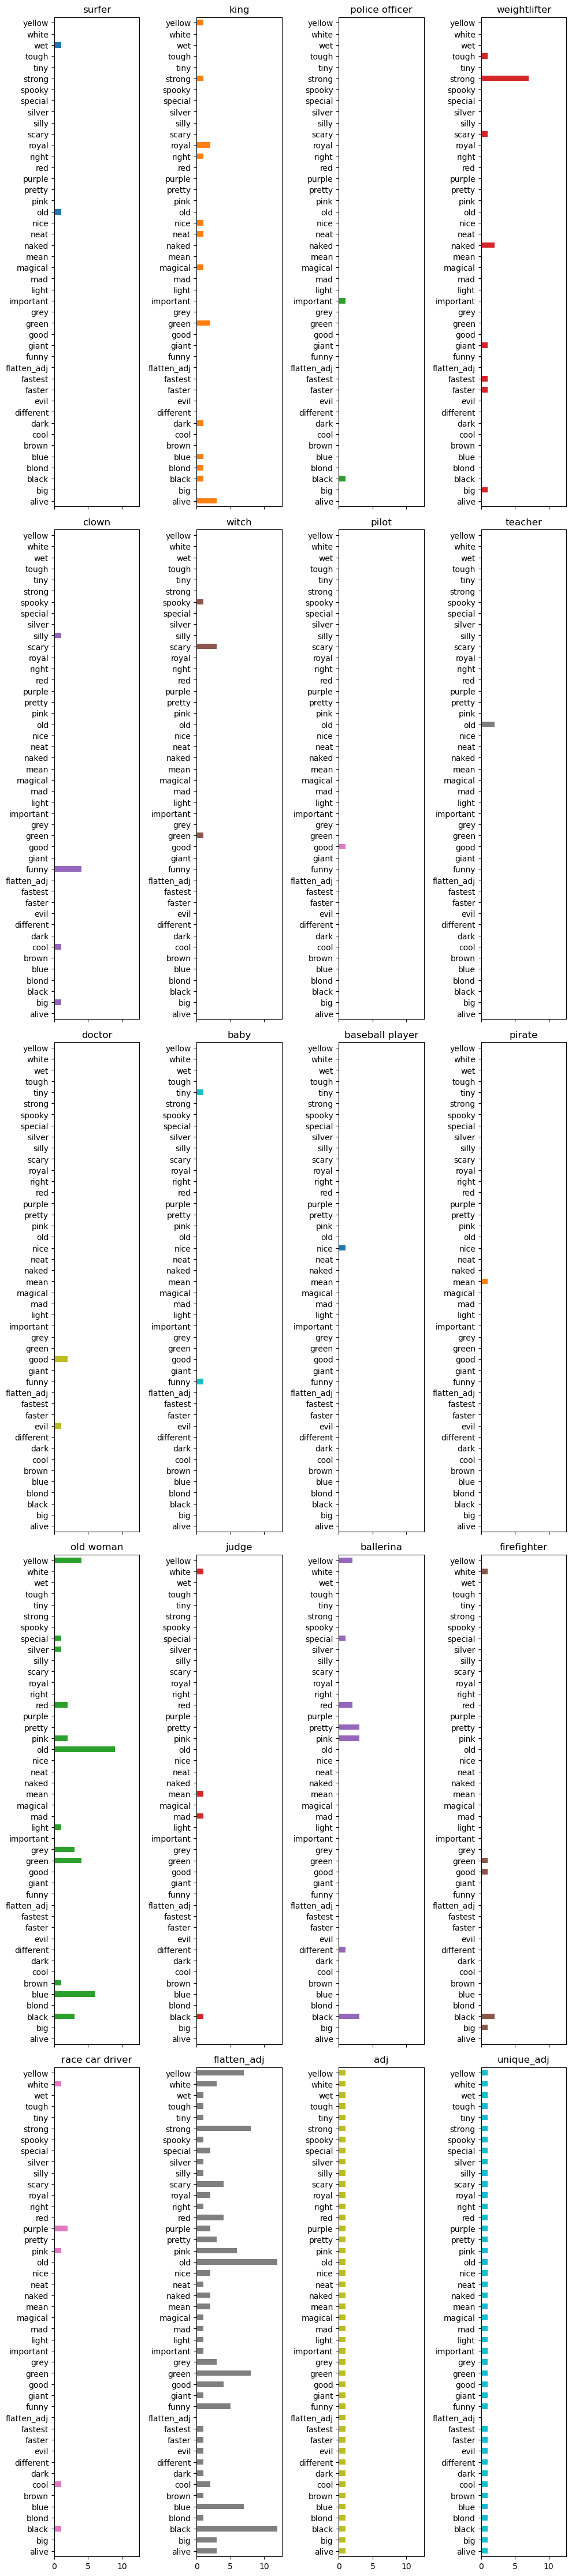

In [192]:
# Frequency Plot Method 1: after further cleaning and manual check in Excel
# Created the distribution plot for each social referent
import matplotlib.pyplot as plt


def plot_adj_counts(df, figsize=(10, 80), layout=(9, 4)):
    # Calculate value counts for each column
    df_counts = df.apply(lambda x: x.value_counts())

    # Plot the value counts
    df_counts.plot(
        kind="barh",
        subplots=True,
        layout=layout,
        legend=False,
        figsize=figsize,
        sharex=True,
    )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


file_path = dir.parent / "Data" / "Spacytest_social_trfpipeline - plot design.csv"
df2 = pd.read_csv(file_path)
plot_adj_counts(df2)

231


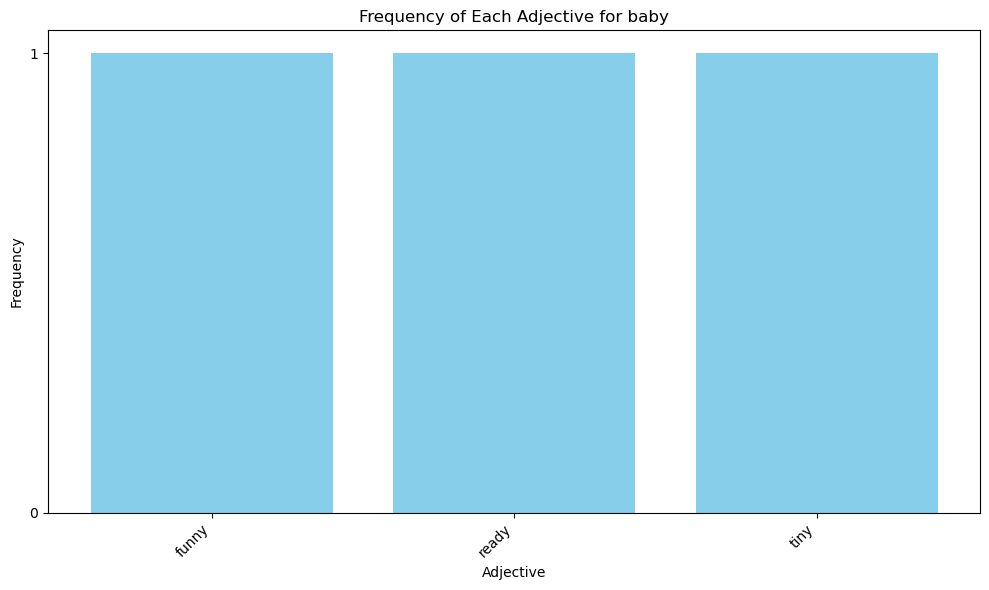

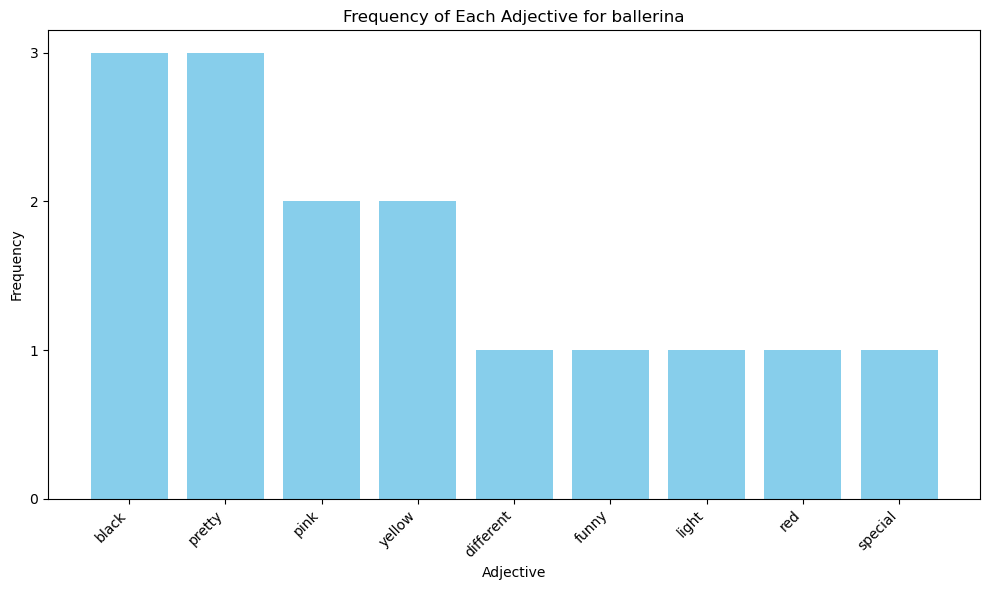

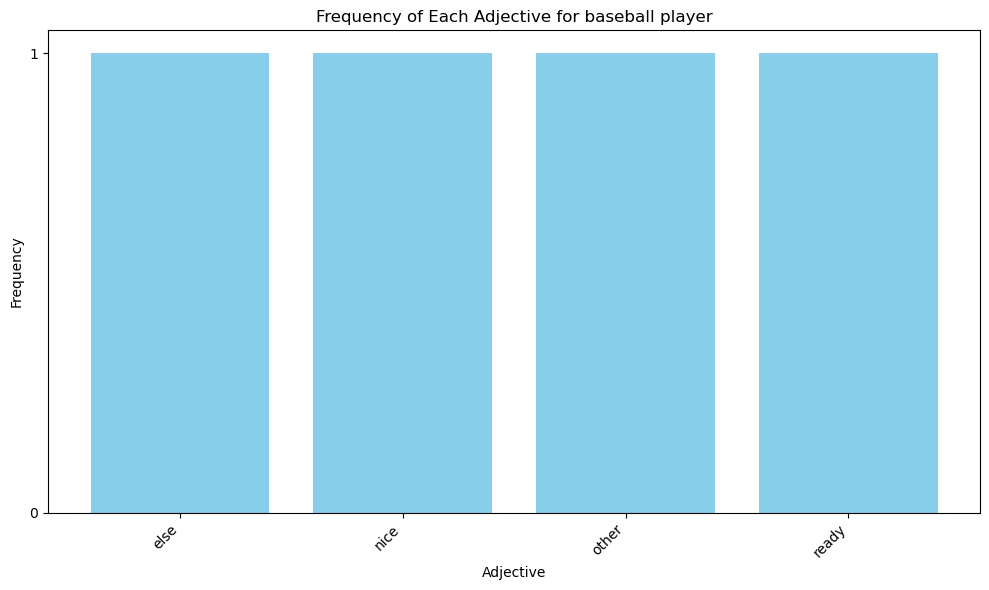

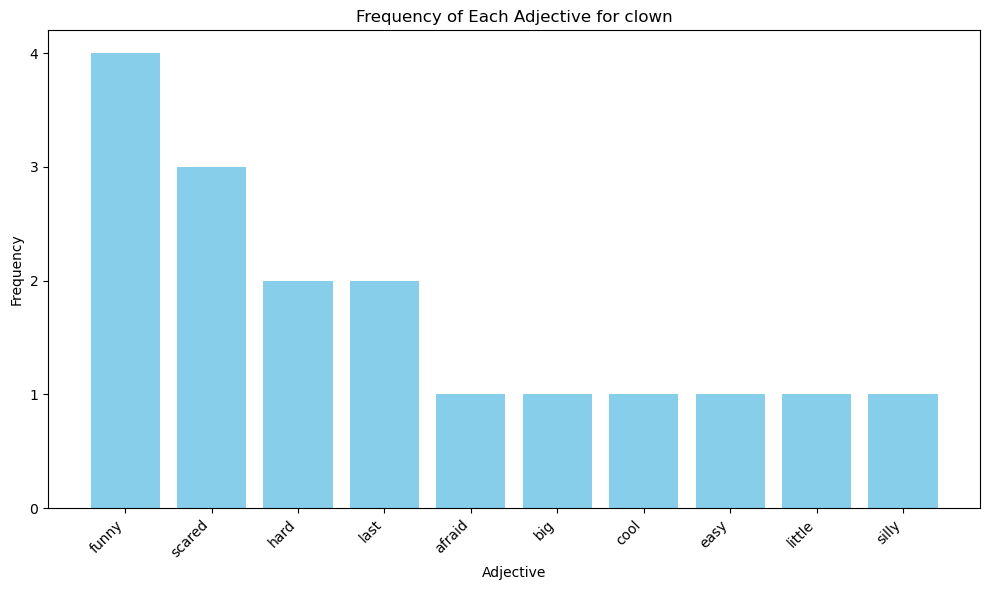

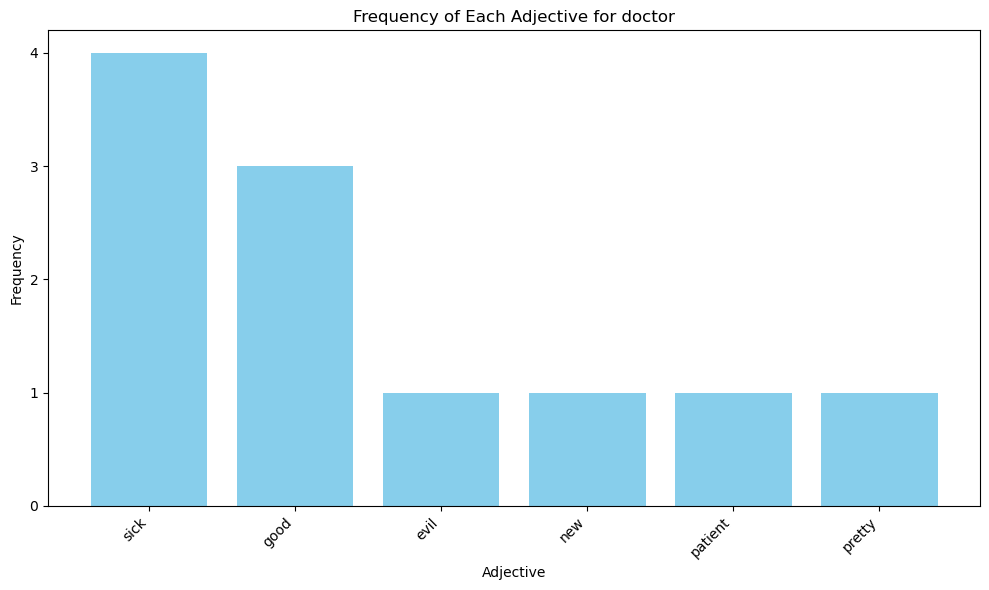

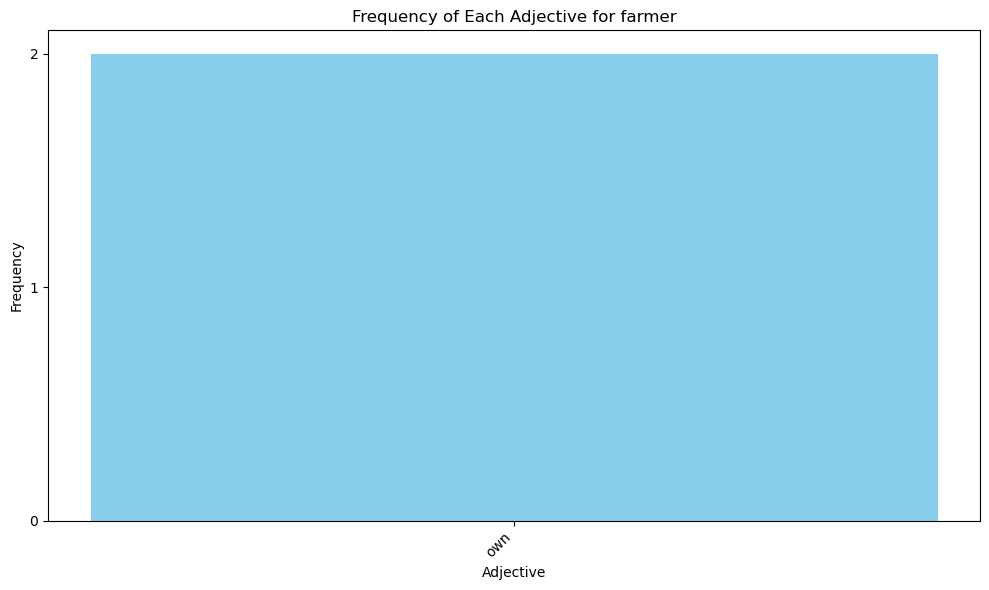

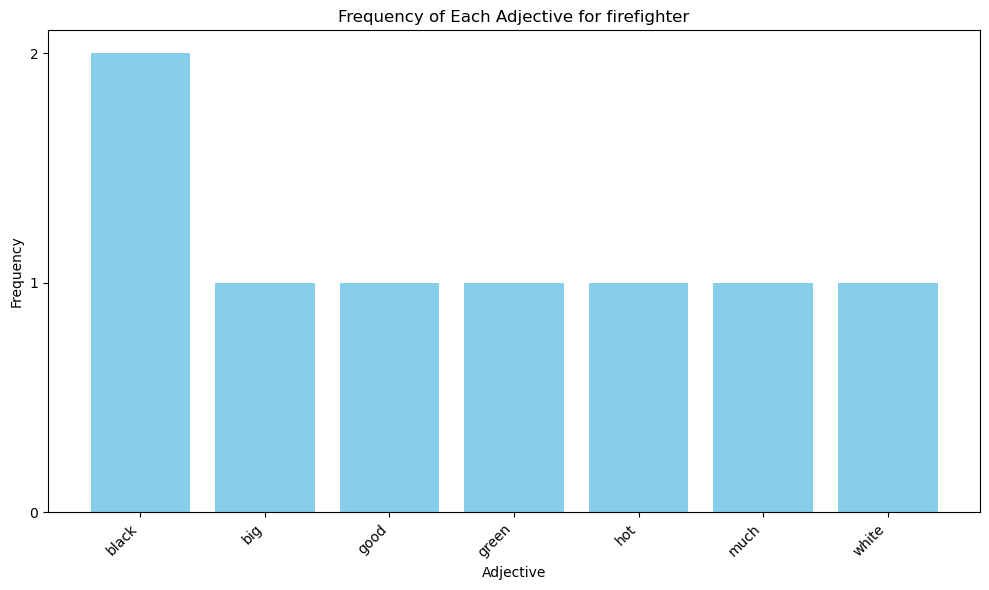

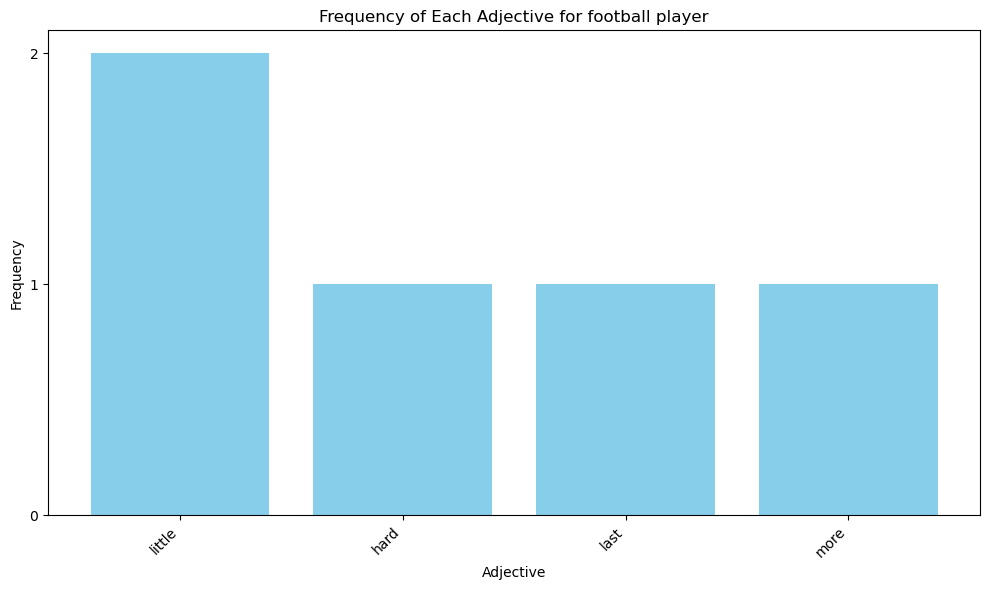

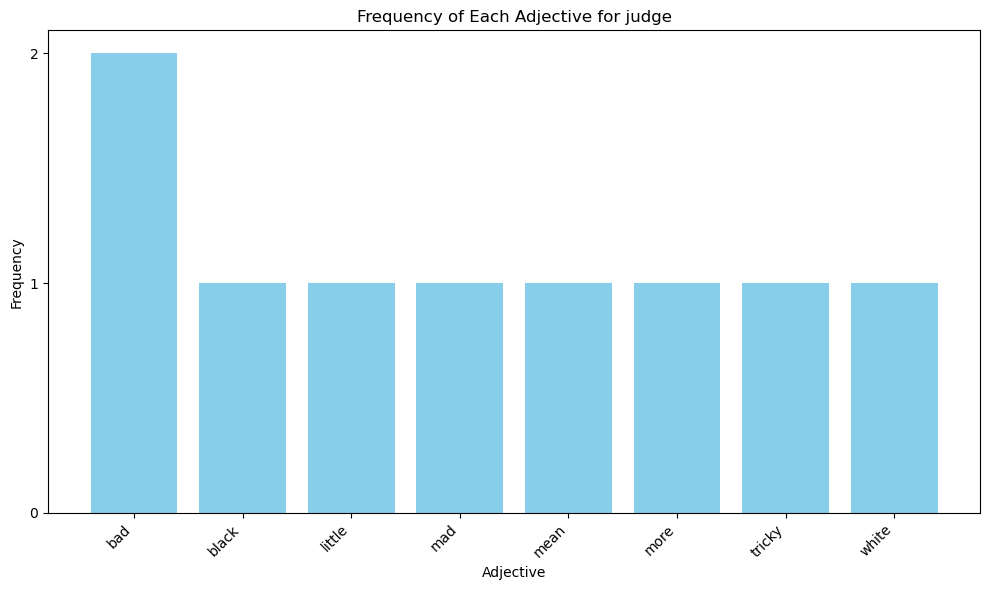

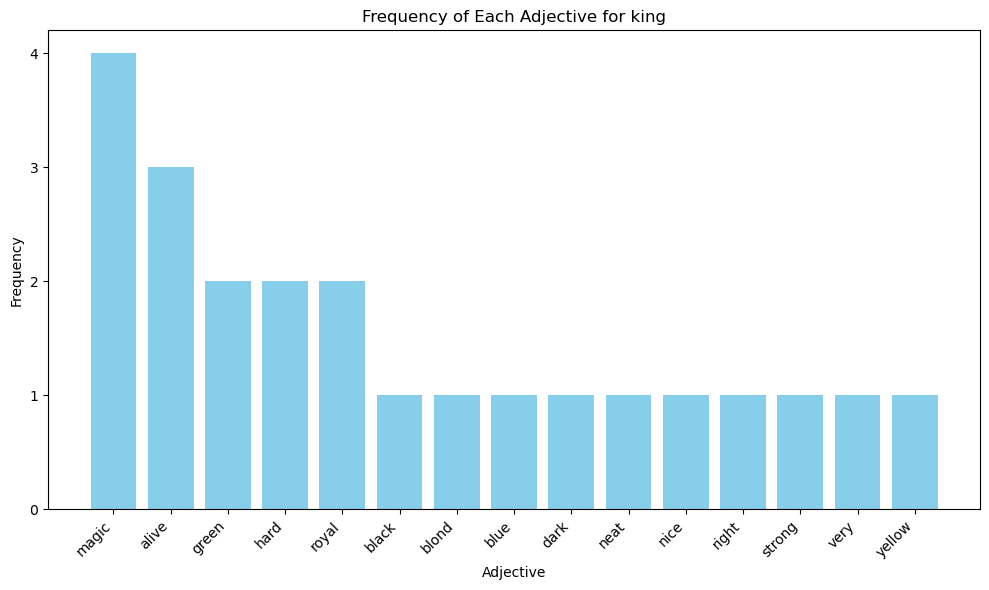

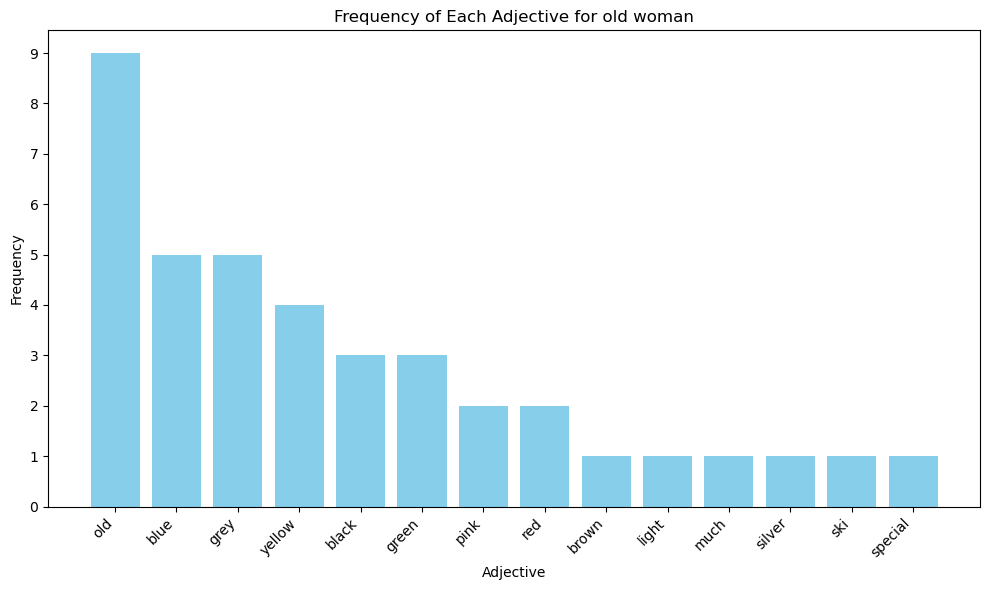

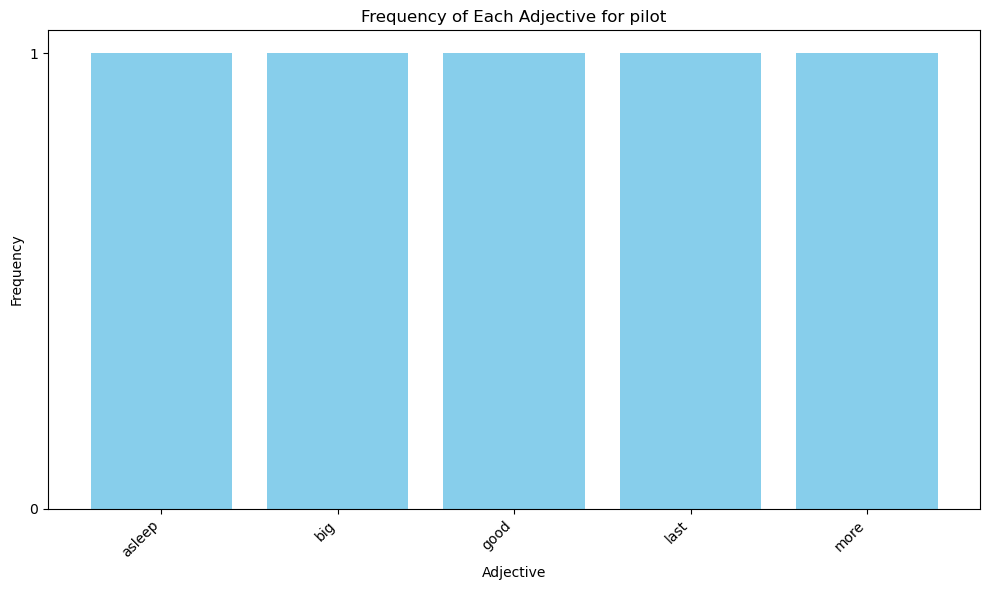

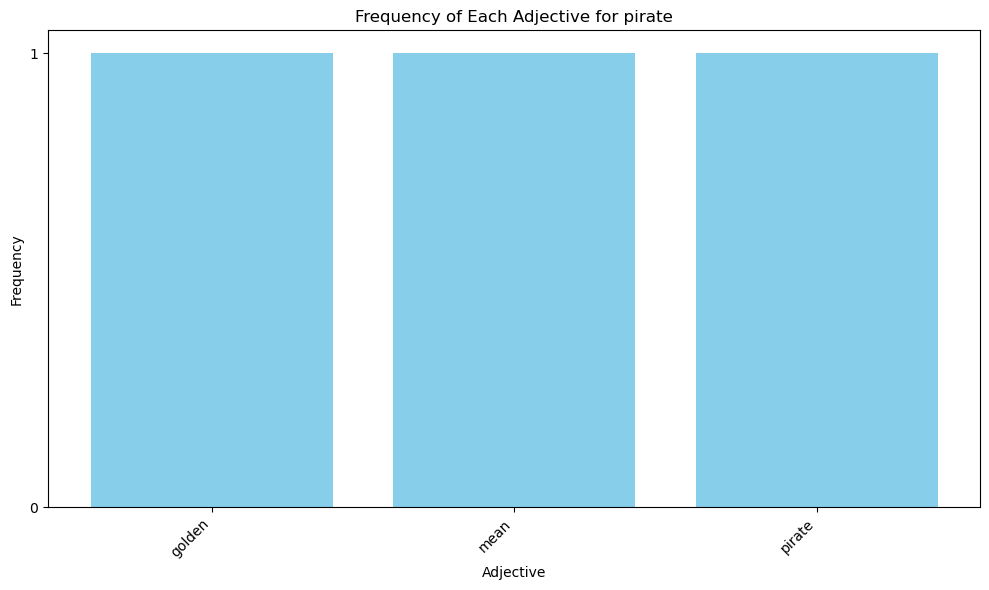

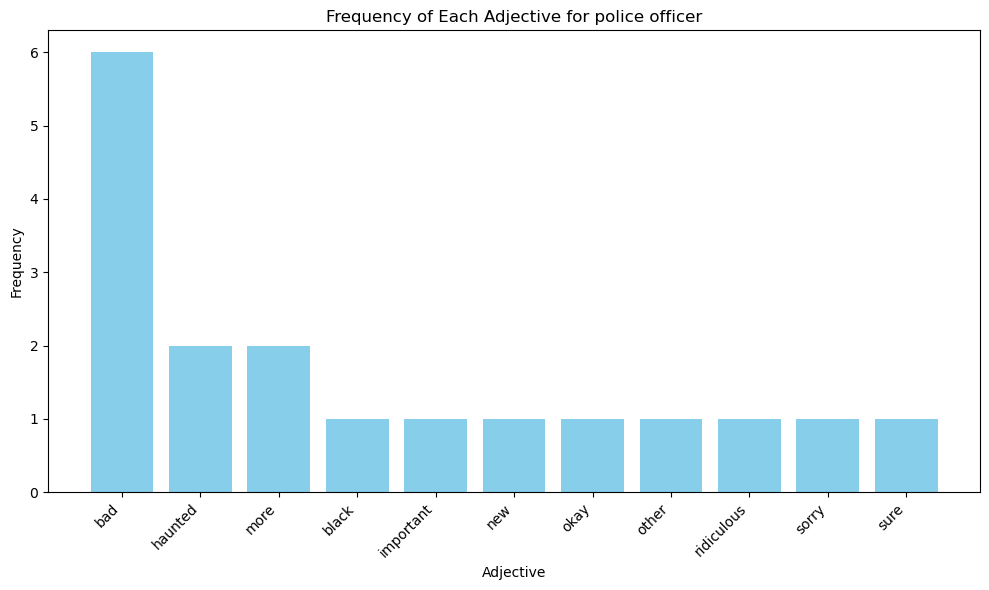

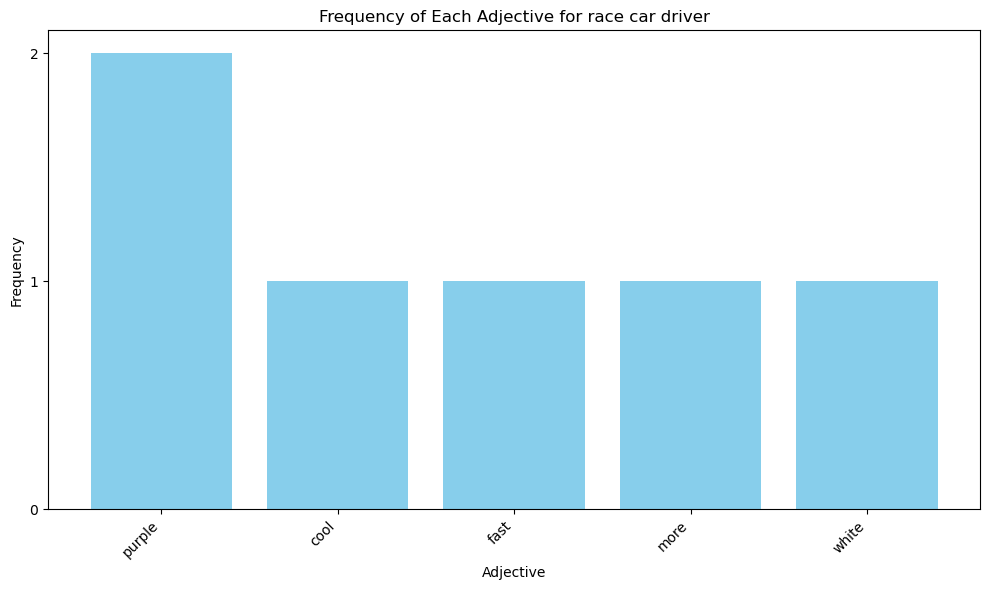

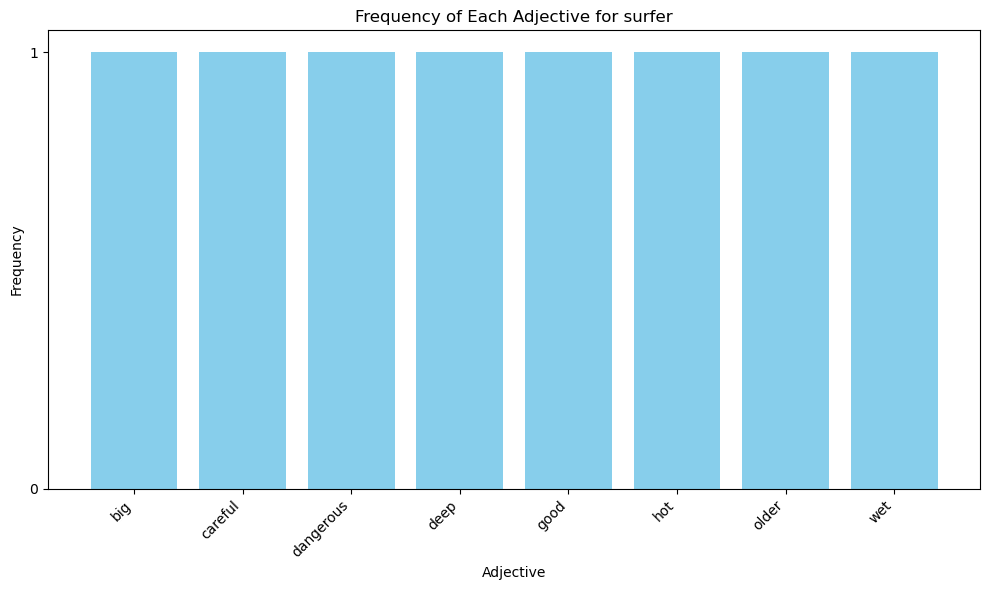

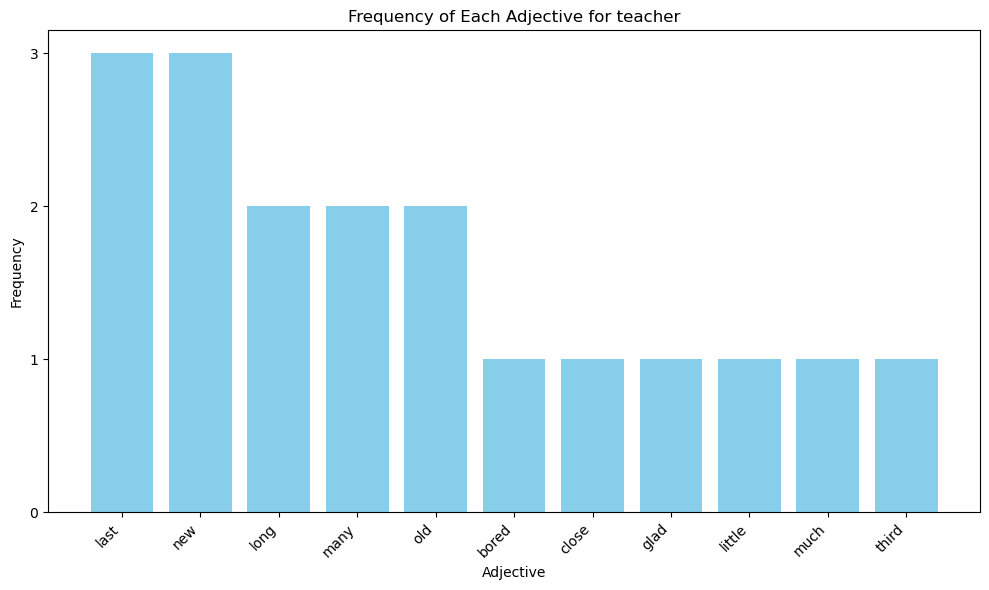

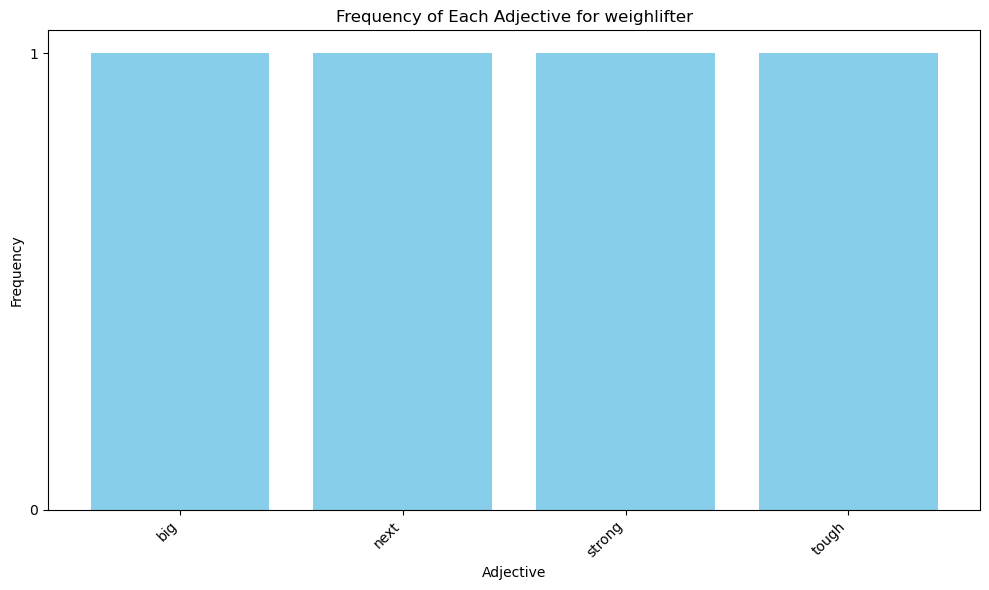

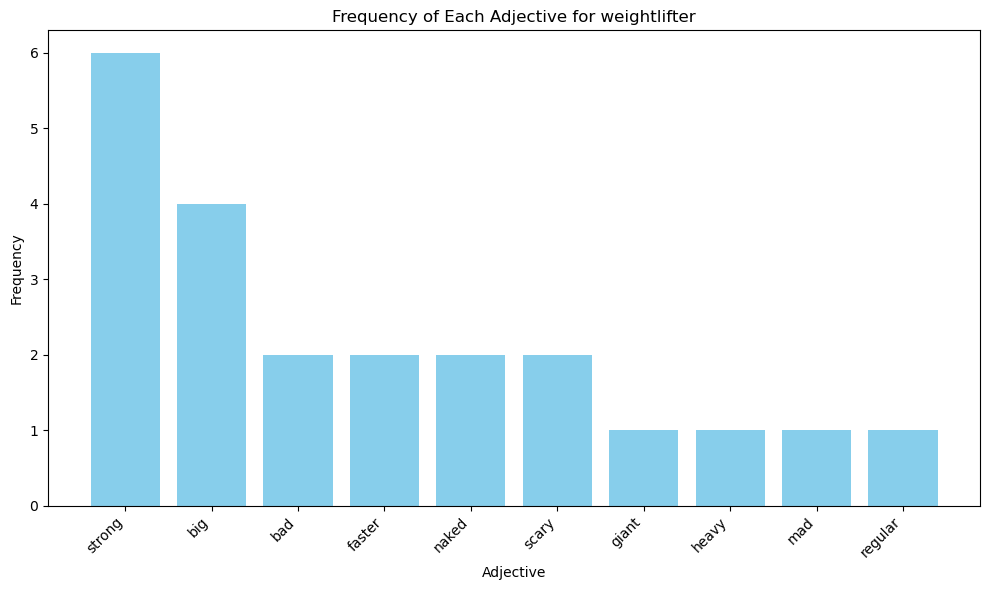

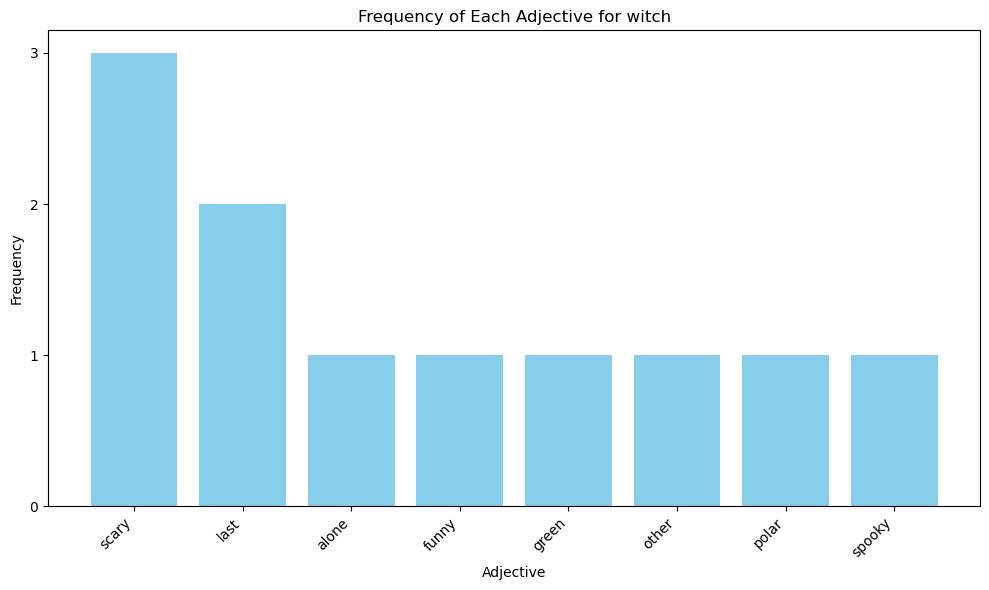

In [237]:
# Frequency Plot Method 2: Plot based on built referent-adj dictionary
def plot_adj_freq_by_referent(adj_dict):
    # Convert the adjacency dictionary to a DataFrame
    adj_list = [(referent, adj) for referent, adjs in adj_dict.items() for adj in adjs]
    df = pd.DataFrame(adj_list, columns=["Referent", "Adjective"])

    # Group by referent and adjective, then calculate the frequency
    adj_freq = df.groupby(["Referent", "Adjective"]).size().reset_index(name="Count")
    total_adjectives_count = adj_freq["Count"].sum()

    print(total_adjectives_count)

    unique_referents = adj_freq["Referent"].unique()

    for referent in unique_referents:
        referent_adj_freq = adj_freq[adj_freq["Referent"] == referent]
        referent_adj_freq = referent_adj_freq.sort_values(by="Count", ascending=False)

        plt.figure(figsize=(10, 6))
        plt.bar(
            referent_adj_freq["Adjective"], referent_adj_freq["Count"], color="skyblue"
        )
        plt.xlabel("Adjective")
        plt.ylabel("Frequency")
        plt.title(f"Frequency of Each Adjective for {referent}")
        plt.xticks(rotation=45, ha="right")
        max_count = referent_adj_freq["Count"].max()
        plt.yticks(range(0, max_count + 1, 1))

        plt.tight_layout()
        plt.show()


plot_adj_freq_by_referent(adj_dict)

## Top 10 Adjectives

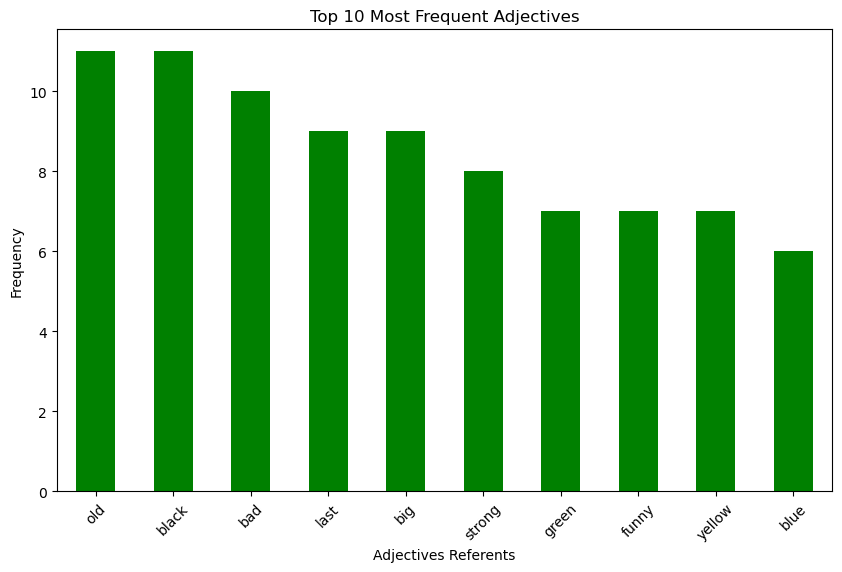

In [238]:
def plot_top_adjectives(adj_dict, top_n=10):
    # Convert the adjacency dictionary to a DataFrame
    adj_list = [(referent, adj) for referent, adjs in adj_dict.items() for adj in adjs]
    df = pd.DataFrame(adj_list, columns=["Referent", "Adjective"])

    # Calculate the frequency of each adjective
    adjective_freq = df["Adjective"].value_counts()

    # Select the top N adjectives
    top_adjectives = adjective_freq.head(top_n)

    # Plot the top N adjectives
    top_adjectives.plot(kind="bar", color="green", figsize=(10, 6))

    # Set plot title and labels
    plt.title(f"Top {top_n} Most Frequent Adjectives")
    plt.xlabel("Adjectives Referents")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()


plot_top_adjectives(adj_dict)

* Keep in mind, adjectives we parsed are not necessarily describing the referent, but other objects in the sentence. Therefore, I introduce the n-gram analysis to trace the object the adjective is directly related to.

## N-gram Analysis (Modified as N-distance here for bigram)

In [195]:
# n-grams for spacy objects (noun_adj pairs)
def n_grams(doc, n, pair_list):
    tokens = [
        token for token in doc if not token.is_stop and token.pos_ in {"NOUN", "ADJ"}
    ]
    for i in range(len(tokens) - n + 1):
        n_gram = tokens[i : i + n]
        # Loop through each token in the n-gram
        for token in n_gram:
            # Check if the token is an adjective
            if token.pos_ == "ADJ":
                # Check if the head of the adjective is a noun and is in the same n-gram
                if token.head.pos_ == "NOUN" and token.head in n_gram:
                    # Use lemmatized form for both noun and adjective
                    # To avoid duplicates which are counted differently (e.g., (guys, bad), (guy, bad))
                    pair = (
                        token.lemma_,
                        token.head.lemma_,
                    )  # (Noun, Adjective)
                    pair_list.append(pair)

    return pair_list


pair_list = []
for strings in df["Speech"]:
    cleaned_text = clean_text(strings)
    doc = nlp(cleaned_text)
    n_grams(doc, 4, pair_list)

In [196]:
pd.Series(pair_list).info()

<class 'pandas.core.series.Series'>
RangeIndex: 31 entries, 0 to 30
Series name: None
Non-Null Count  Dtype 
--------------  ----- 
31 non-null     object
dtypes: object(1)
memory usage: 380.0+ bytes


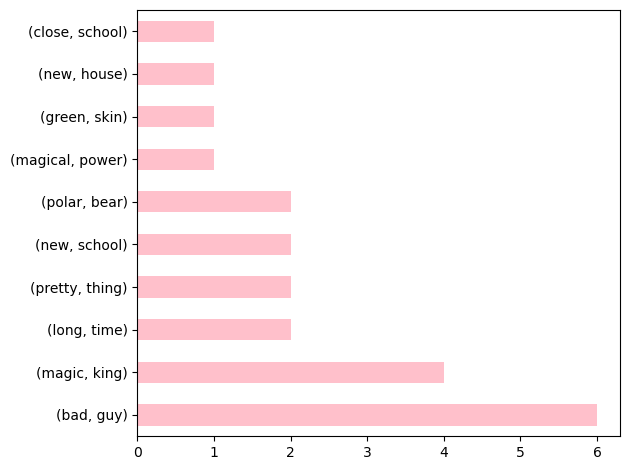

In [197]:
bigrams = pd.Series(pair_list).value_counts()[:10]
bigrams.plot(kind="barh", color="pink")

max_count = bigrams.max()
plt.xticks(range(0, max_count + 1, 1))
plt.tight_layout()
plt.show()

## PCA TF-IDF Analysis

* TF-IDF: This is the product of TF and IDF. 
* It represents the importance of a term in a document relative to the entire corpus. Terms with high TF-IDF scores are those that are frequent in the document but rare in the corpus, indicating their significance in describing the content of the document.

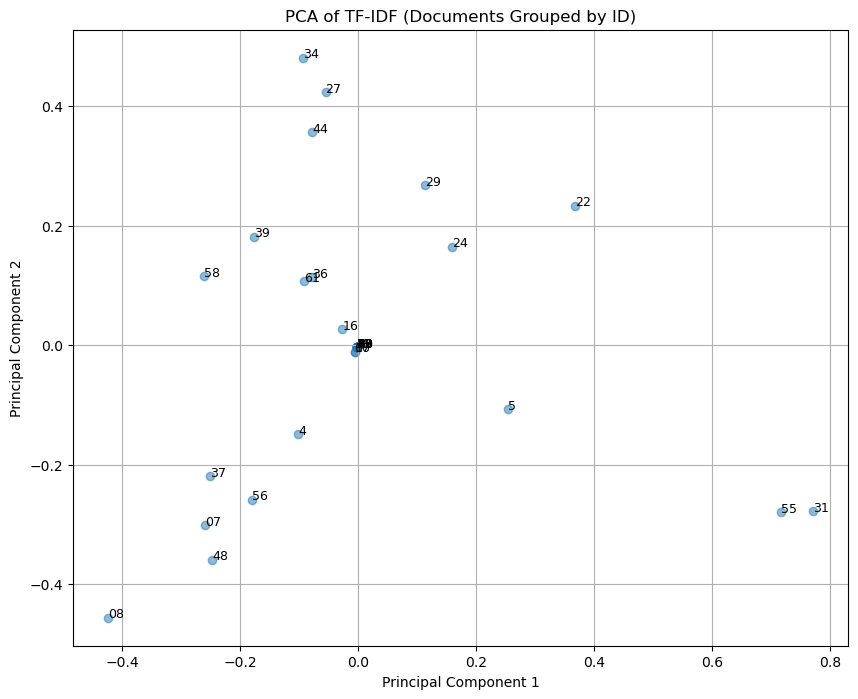

In [239]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


def adj_perform_across_children(df, perform_clustering=False):
    # Step 1: Extract Document Identifier
    df["DocID"] = df["Participant ID"].str.extract(r"(\d{1,2})")

    # Step 2: Group Text by Identifier
    grouped_text = (
        df.groupby("DocID")["Adjectives_Spacy"]
        .apply(
            lambda adjectives_list: " ".join(
                [word for sublist in adjectives_list.dropna() for word in sublist]
            )
        )
        .reset_index()
    )

    # Step 3: Generate TF-IDF Matrix
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(
        grouped_text["Adjectives_Spacy"]
    ).toarray()

    # Step 4: Apply PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(tfidf_matrix)

    # Plot PCA without clustering
    plt.figure(figsize=(10, 8))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)

    # Annotate each point with its DocID
    for i, doc_id in enumerate(grouped_text["DocID"]):
        plt.text(
            principal_components[i, 0], principal_components[i, 1], doc_id, fontsize=9
        )

    plt.title("PCA of TF-IDF (Documents Grouped by ID)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()

    # Optionally perform KMeans clustering
    if perform_clustering:
        # Step 5: Apply K-means clustering
        kmeans = KMeans(n_clusters=3)
        cluster_labels = kmeans.fit_predict(principal_components)

        # Plot PCA with cluster labels
        plt.figure(figsize=(10, 8))
        plt.scatter(
            principal_components[:, 0],
            principal_components[:, 1],
            c=cluster_labels,
            alpha=0.5,
        )

        # Annotate each point with its DocID
        for i, doc_id in enumerate(grouped_text["DocID"]):
            plt.text(
                principal_components[i, 0],
                principal_components[i, 1],
                doc_id,
                fontsize=9,
            )

        plt.title("PCA of TF-IDF with K-means Clustering")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.grid(True)
        plt.colorbar(label="Cluster Label")
        plt.show()


# Example usage without clustering
adj_perform_across_children(df, perform_clustering=False)

* Each point represents a document grouped by Children's Participant ID. 
* The closeness of points in the plot indicates similarity or dissimilarity between the documents based on the adjectives they contain.
* Points that are close together in the plot represent children that have similar distributions of adjectives in the TF-IDF space. 
* This suggests that four-year-old children share common adjective utterance patterns, regarding social referent description.


In [240]:
# Network Attempt Update
# reference to this link: https://pyvis.readthedocs.io/en/latest/tutorial.html
# %pip install pyvis
from pyvis.network import Network


def create_network_visualization(adj_dict, output_filename="network.html"):
    """
    Creates a network visualization from an adjacency dictionary where keys are referents
    and values are lists of adjectives. The visualization is saved to the specified output file.

    Parameters:
    - adj_dict: Dictionary with referents as keys and lists of adjectives as values.
    - output_filename: Name of the file to save the network visualization.
    """
    # Convert adj_dict to DataFrame
    adj_list = [(referent, adj) for referent, adjs in adj_dict.items() for adj in adjs]
    df = pd.DataFrame(adj_list, columns=["Referent", "Adjective"])

    # Count occurrences of each referent-adjective pair
    pair_counts = (
        df.groupby(["Referent", "Adjective"]).size().reset_index(name="Weight")
    )

    # Initialize Pyvis Network
    got_net = Network(
        height="750px", width="100%", bgcolor="#222222", font_color="white"
    )

    # Add nodes and weighted edges
    for _, row in pair_counts.iterrows():
        src, dst, weight = row["Referent"], row["Adjective"], row["Weight"]
        got_net.add_node(src, src, title=src)
        got_net.add_node(dst, dst, title=dst, color="pink")
        got_net.add_edge(src, dst, value=weight)

    # Add neighbor data to node hover data
    for node in got_net.nodes:
        node["title"] += " Neighbors: " + ", ".join(got_net.get_adj_list()[node["id"]])
        node["value"] = len(
            got_net.get_adj_list()[node["id"]]
        )  # Node size based on connections

    # Save or display the network graph
    full_output_path = str(dir.parent / "Result" / output_filename)
    got_net.save_graph(full_output_path)

In [241]:
create_network_visualization(adj_dict, output_filename="social_adj_referent.html")

# Validation Test on Existing Labelled Noun and Pronoun Database

In [207]:
# Function to perform cross-validation on linguistic databases
def reliability_check_trf(df, nlp):
    noun = []
    pronoun = []
    for text in df["transcribe.content"].astype(str):
        cleaned_text = clean_text(text)  # Assuming this function is defined elsewhere
        doc = nlp(cleaned_text)
        noun_count = sum(
            1 for token in doc if token.pos_ in ["NOUN", "PROPN", "NUM", "X"]
        )
        pronoun_count = sum(1 for token in doc if token.pos_ in ["PRON"])
        noun.append(noun_count)
        pronoun.append(pronoun_count)

    additional = pd.DataFrame({"Nouns_Spacy": noun, "Pronoun_Spacy": pronoun})
    new_df = pd.concat([df, additional], axis=1)
    return new_df


# Function to calculate accuracy
def calculate_accuracy(df, noun_pre, pronoun_pre):
    m = sum(
        1 for noun, noun_pre in zip(df["Nouns_Spacy"], noun_pre) if noun == noun_pre
    )
    n = sum(
        1
        for pronoun, pronoun_pre in zip(df["Pronoun_Spacy"], pronoun_pre)
        if pronoun == pronoun_pre
    )
    accuracy_noun_spacy = m / len(df["Nouns_Spacy"])
    accuracy_pronoun_spacy = n / len(df["Pronoun_Spacy"])
    return accuracy_noun_spacy, accuracy_pronoun_spacy


df = pd.read_csv(dir.parent / "Data" / "Sample2.csv")

# Clean text and perform reliability check
new_df = reliability_check_trf(df, nlp)

# Calculate accuracy
accuracy_noun, accuracy_pronoun = calculate_accuracy(
    new_df, new_df["Noun (1/0)"], new_df["Pronoun (1/0)"]
)
print("Accuracy for nouns:", accuracy_noun)
print("Accuracy for pronouns:", accuracy_pronoun)

# Save the updated dataframe
new_df.to_csv(dir.parent / "Result" / "Sample2_Spacy.csv")

Accuracy for nouns: 0.8908665105386416
Accuracy for pronouns: 0.8932084309133489


In [208]:
df = pd.read_csv(dir.parent / "Data" / "Sample1.csv")
df.rename(columns={"Transcript": "transcribe.content"}, inplace=True)
# Clean text and perform reliability check
new_df = reliability_check_trf(df, nlp)

# Calculate accuracy
accuracy_noun, accuracy_pronoun = calculate_accuracy(
    new_df, new_df["Noun (1/0)"], new_df["Pronoun (1/0)"]
)
print("Accuracy for nouns:", accuracy_noun)
print("Accuracy for pronouns:", accuracy_pronoun)

# Save the updated dataframe
new_df.to_csv(dir.parent / "Result" / "Sample1_Spacy.csv")

Accuracy for nouns: 0.8659217877094972
Accuracy for pronouns: 0.8901303538175046


## Food Referents

In [209]:
df = pd.read_csv(
    dir.parent
    / "Data"
    / "Master Children Description Data - Master food description.csv",
    usecols=lambda column: column != "Order",
)

df.rename(columns={"ID": "Participant ID"}, inplace=True)
df["Participant ID"] = df["Participant ID"].astype(str)
# Clean the text and extract adjectives
df["Speech"] = df["Speech"].astype(str)
df["Speech"] = df["Speech"].apply(clean_text)
df["Adjectives_Spacy"] = df["Speech"].apply(extract_adjectives)

df.to_csv(dir.parent / "Result" / "food_adj.csv")

In [226]:
# Clean Food Adjective into referent-adj pairs
import ast
import csv


def referent_food_adj_parser(file_path):
    adj_dict = {}

    with open(file_path, "r") as file_obj:
        reader = csv.reader(file_obj)
        next(reader)  # Skip the header row

        for row in reader:
            if row[2] == "nan" or row[0] == "0":
                continue
            referent = row[4].lower()
            referent = clean_referent(referent)

            adj_dict[referent] = adj_dict.get(referent, [])
            try:
                adjectives = ast.literal_eval(row[-1])
                if isinstance(adjectives, list):
                    revised_adjs = []
                    unrevised_adjs = []
                    for current_adj in adjectives:
                        if (
                            update_with_shorter_adjective(
                                adj_dict[referent], current_adj
                            )
                            is not None
                        ):
                            current_adj = update_with_shorter_adjective(
                                adj_dict[referent], current_adj
                            )
                            revised_adjs.append(current_adj)
                        else:
                            unrevised_adjs.append(current_adj)

                    adj_dict[referent].extend(revised_adjs)
                    adj_dict[referent].extend(unrevised_adjs)

            except (ValueError, SyntaxError):
                continue

    return adj_dict


file_path = dir.parent / "Result" / "food_adj.csv"
adj_dict = referent_food_adj_parser(file_path)

256


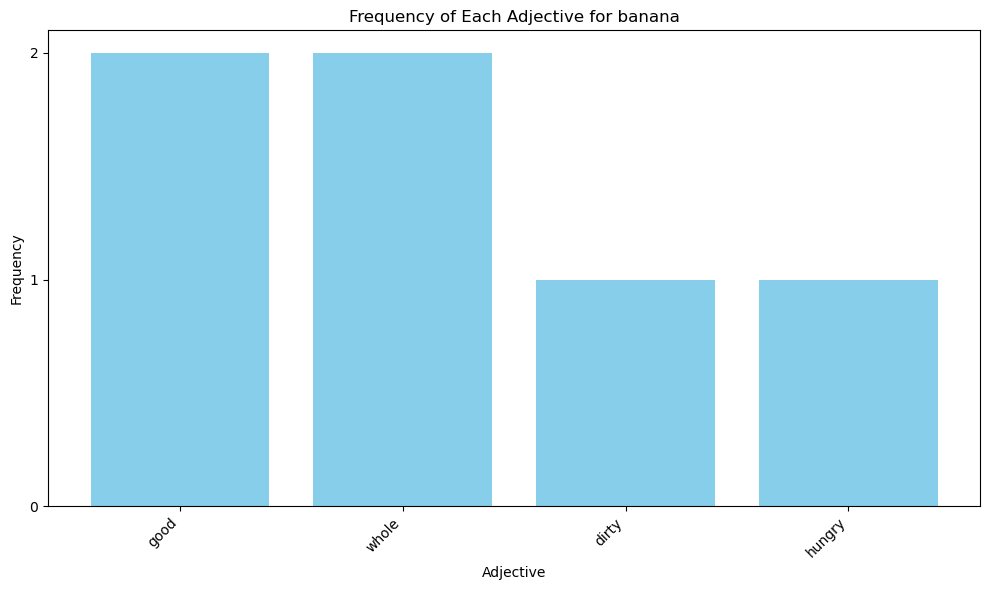

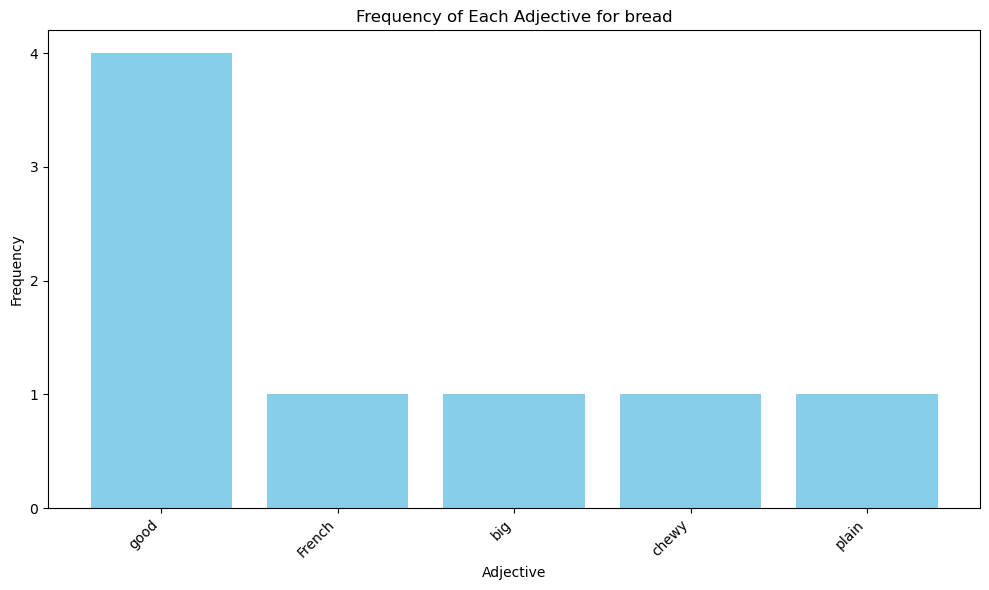

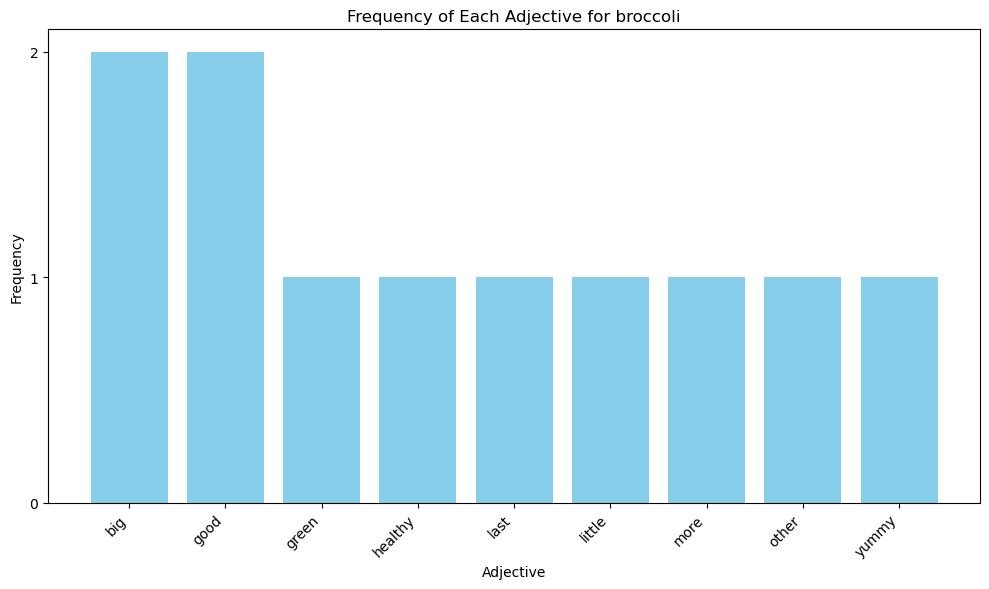

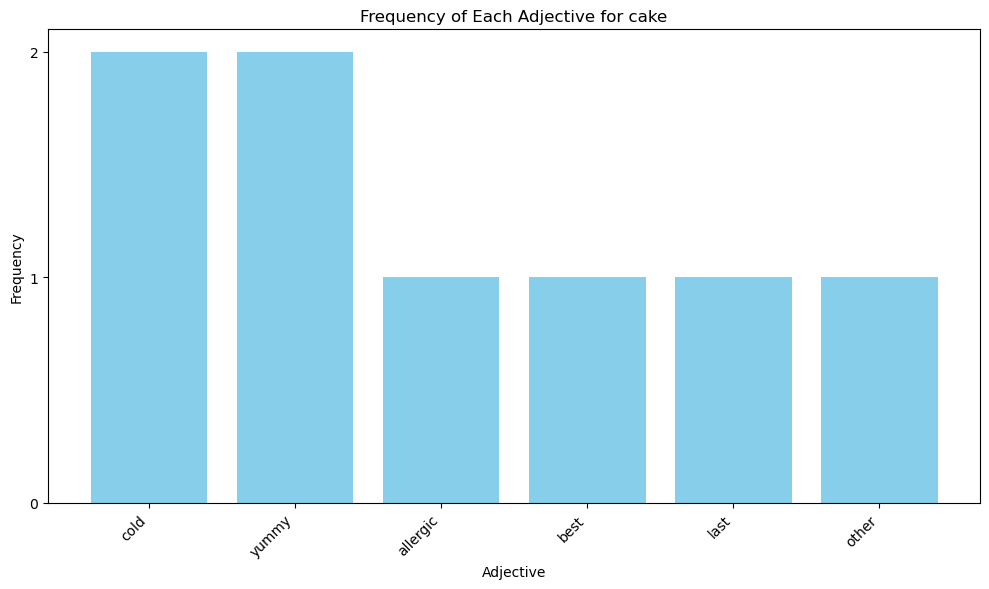

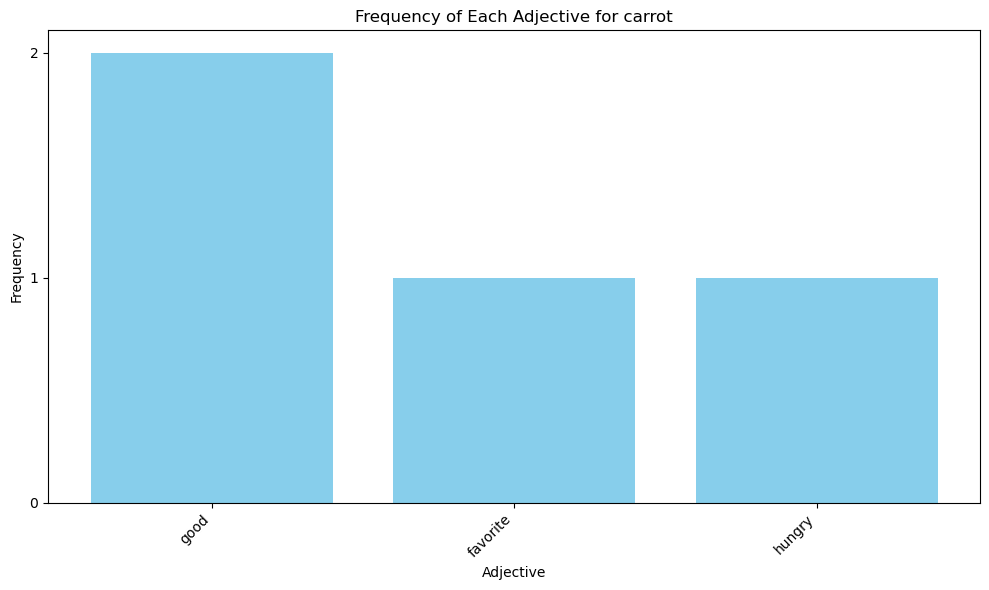

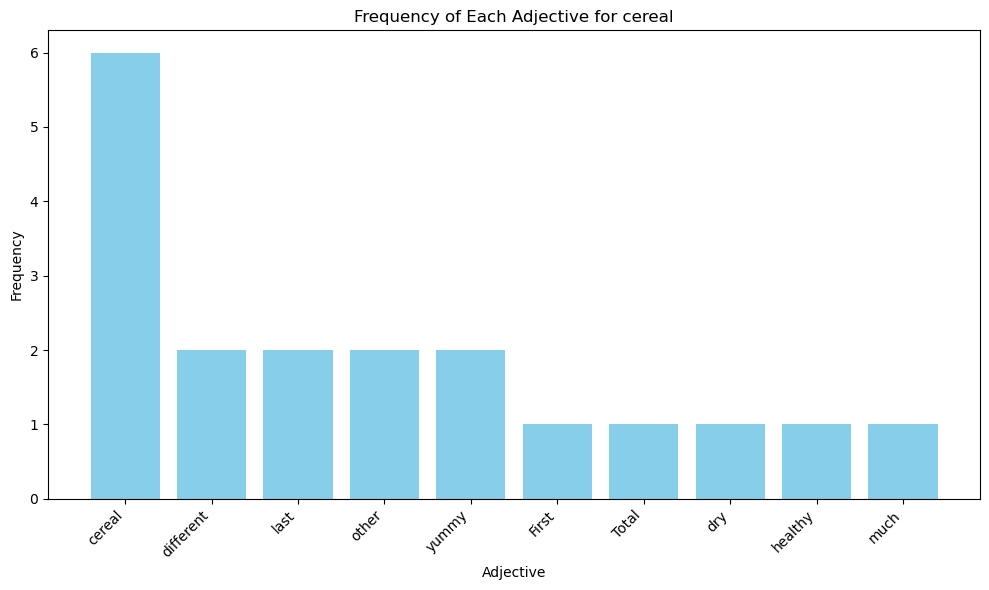

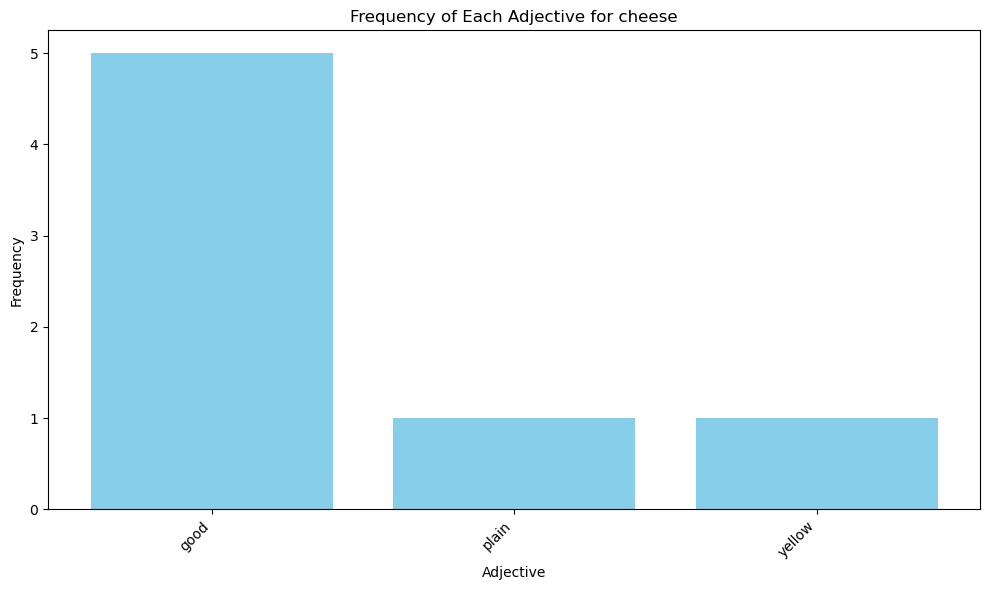

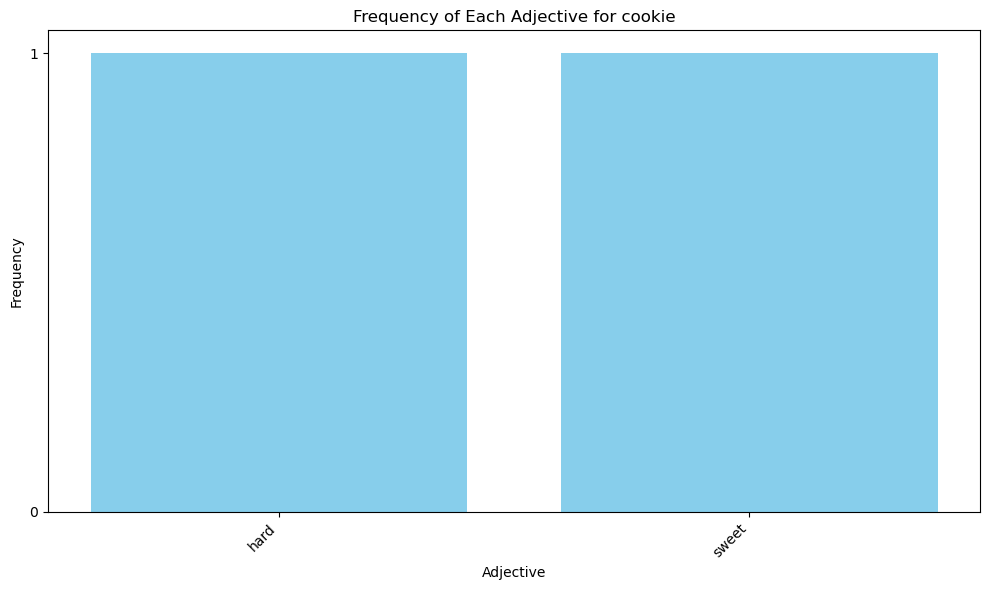

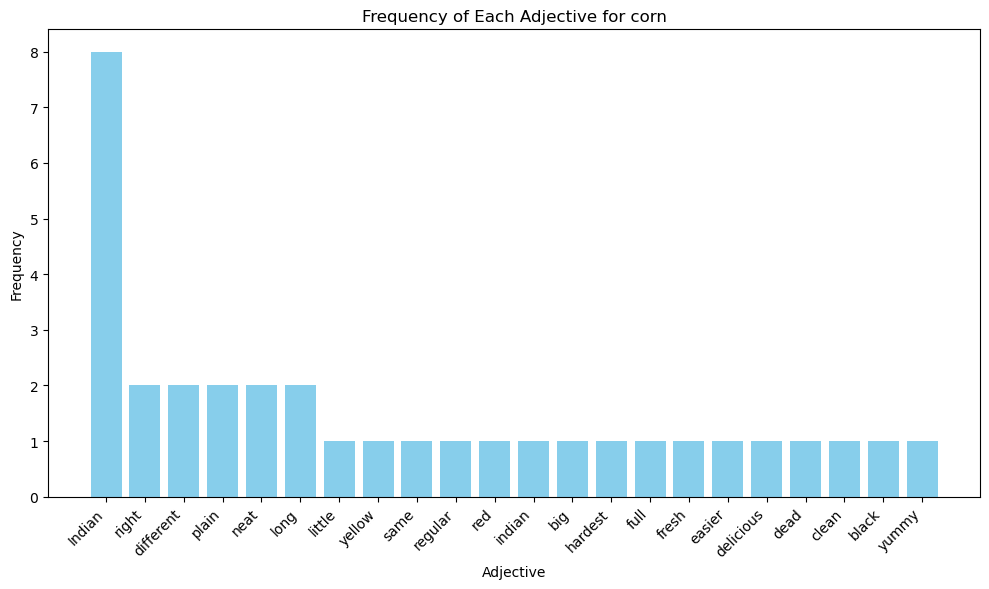

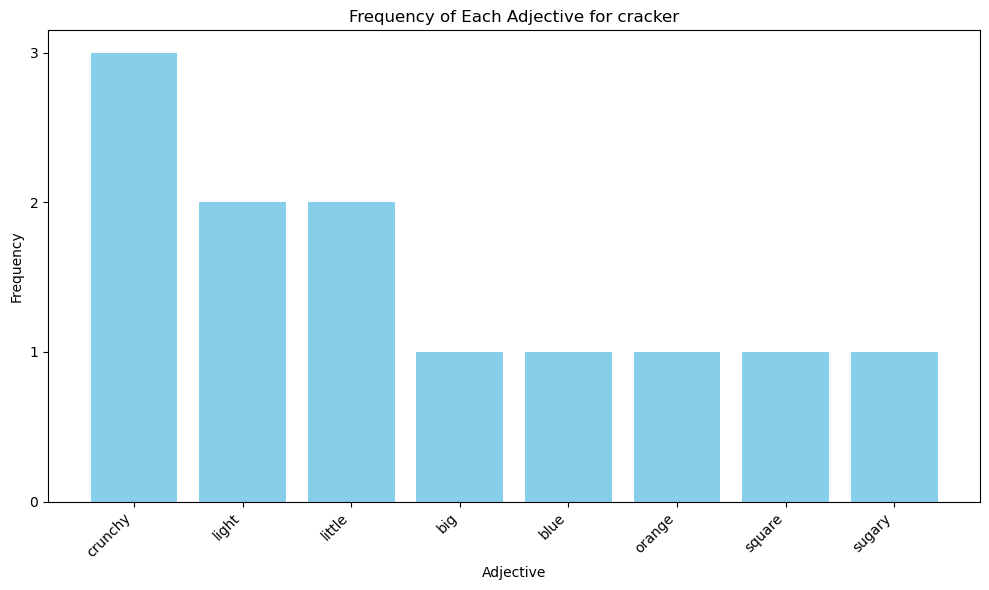

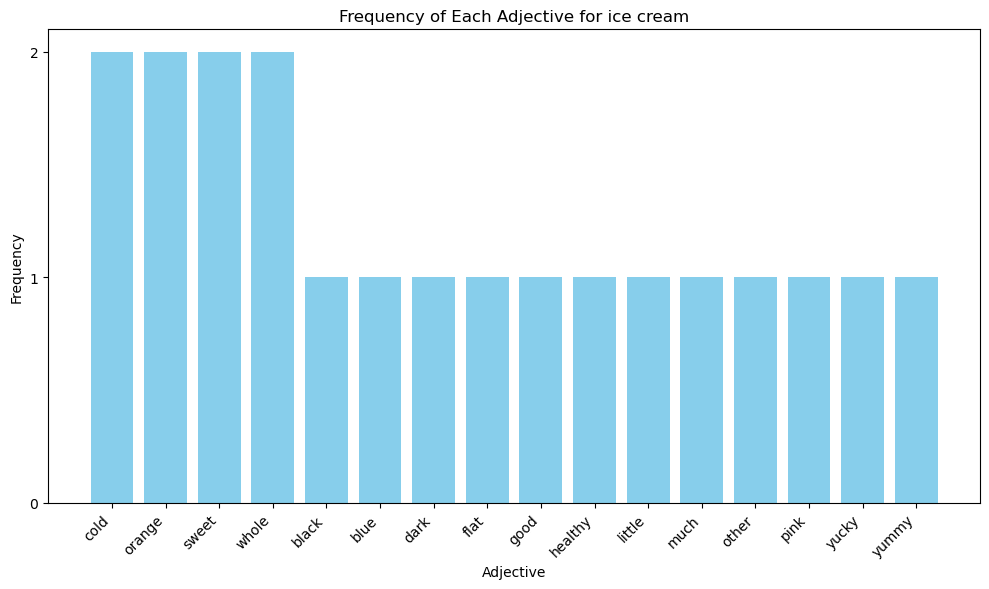

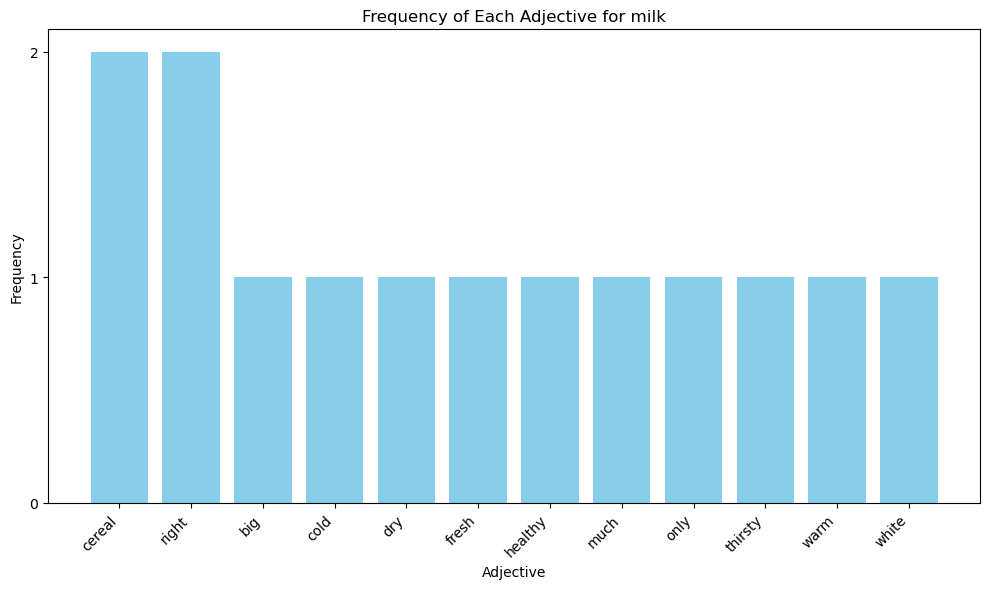

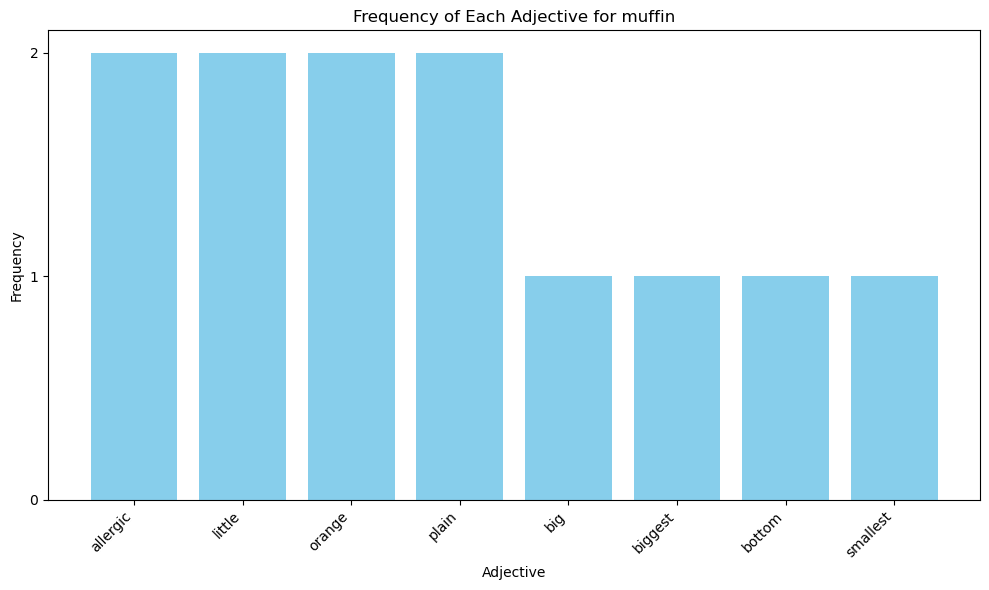

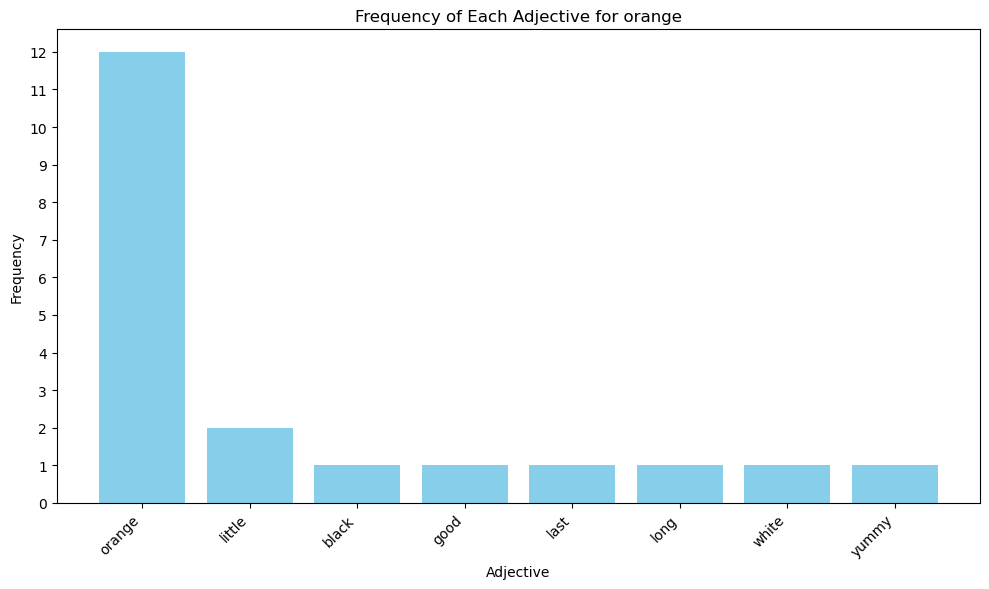

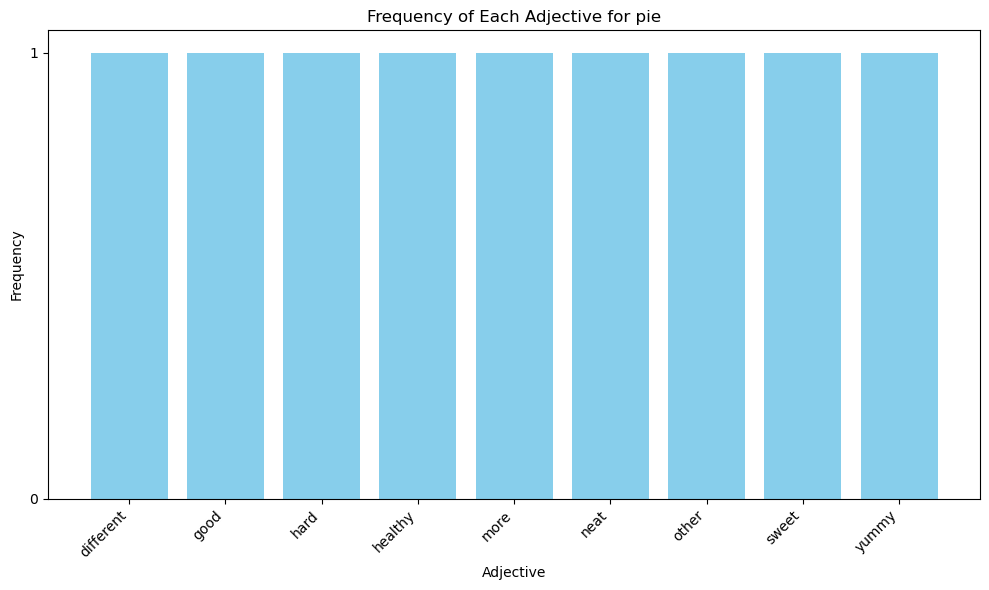

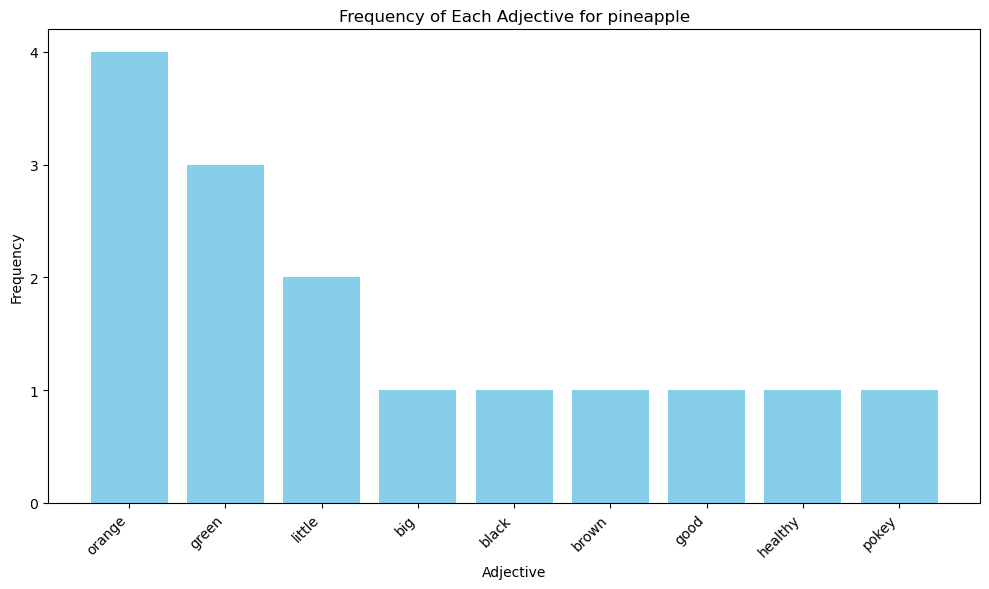

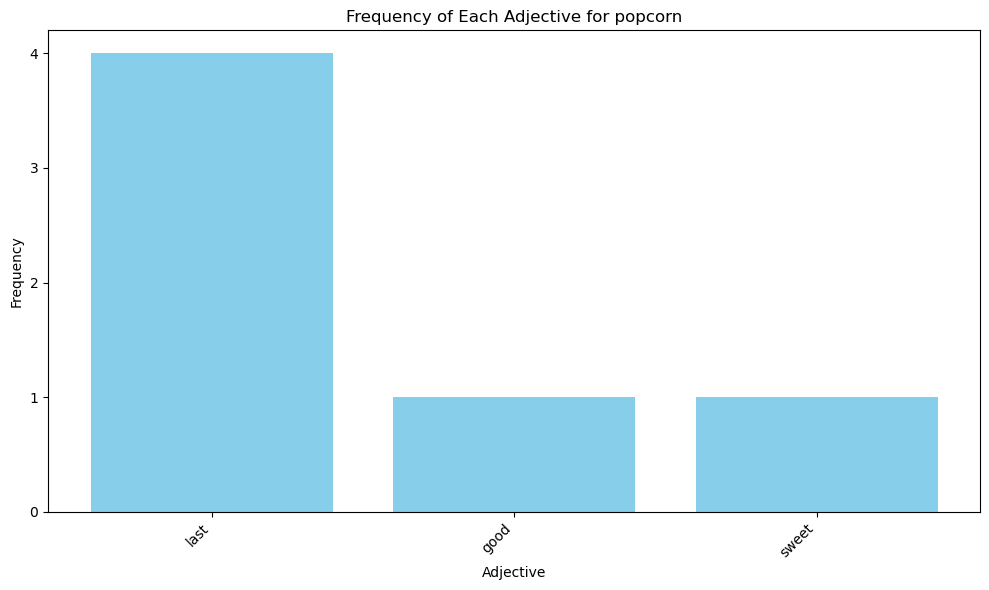

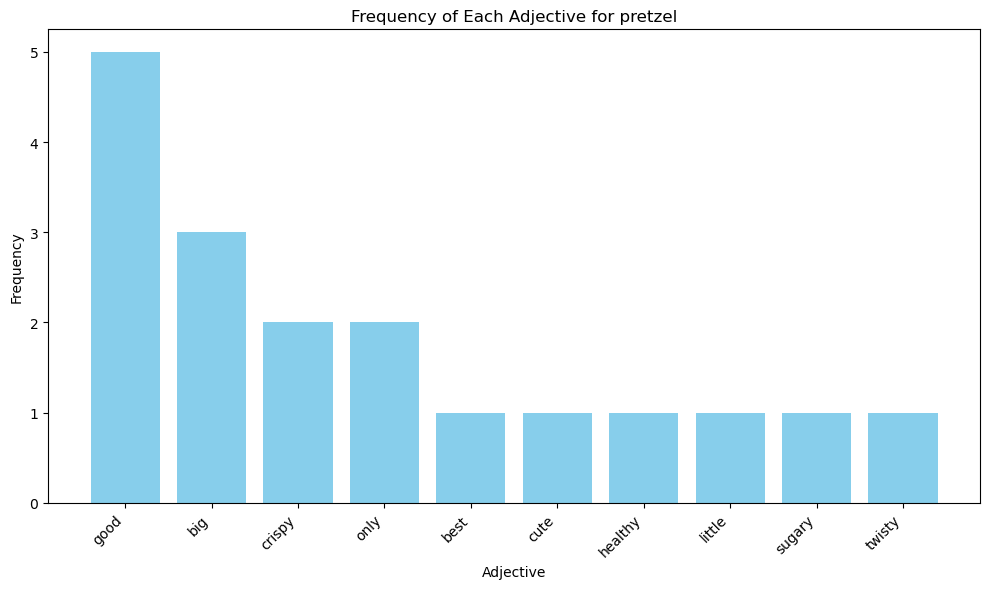

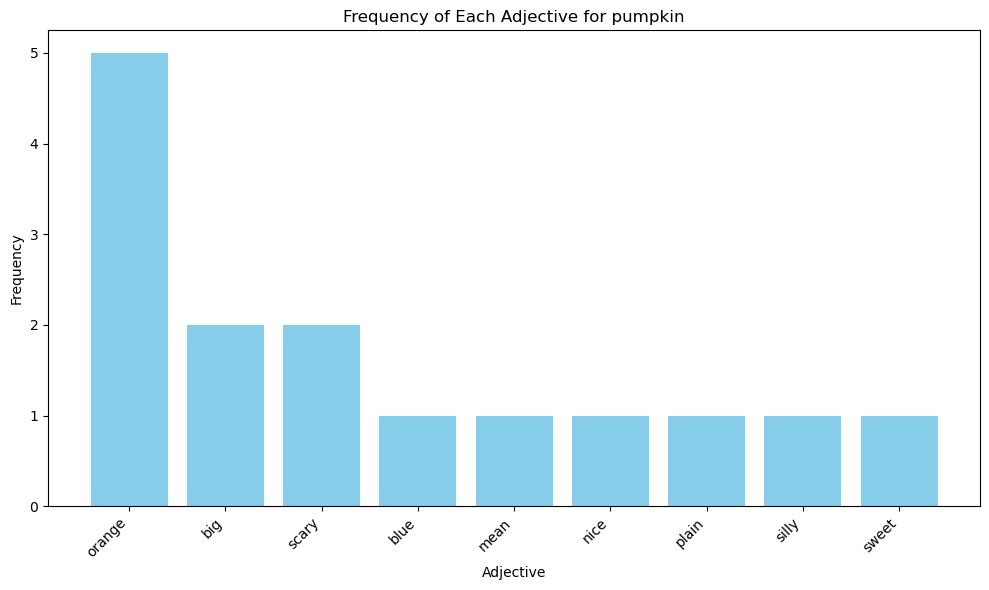

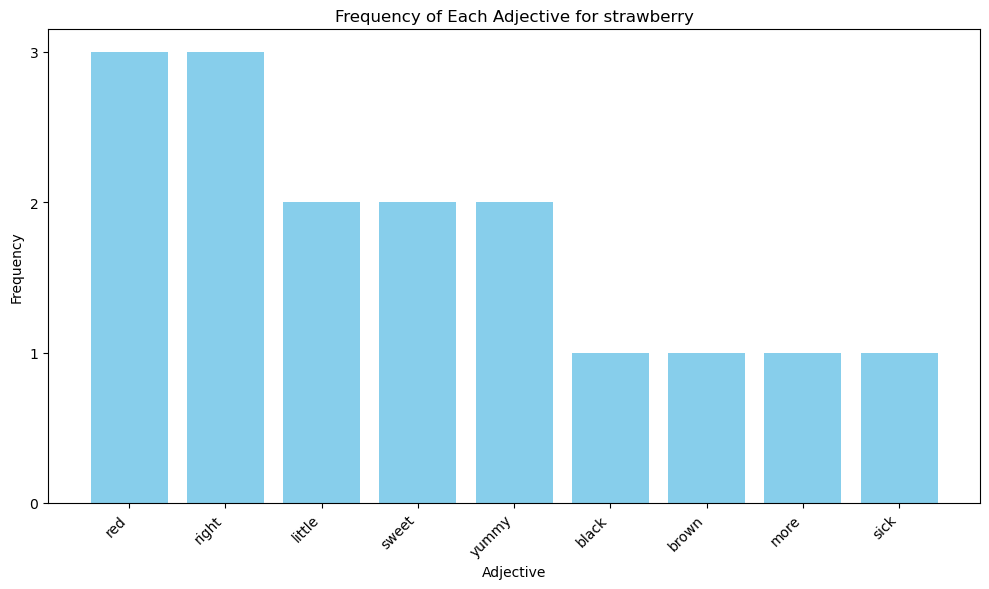

In [227]:
plot_adj_freq_by_referent(adj_dict)

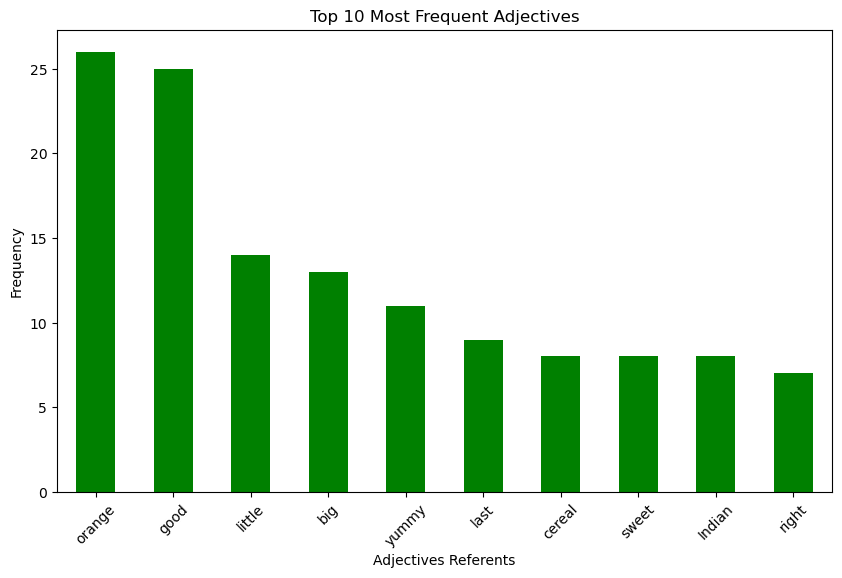

In [228]:
plot_top_adjectives(adj_dict)

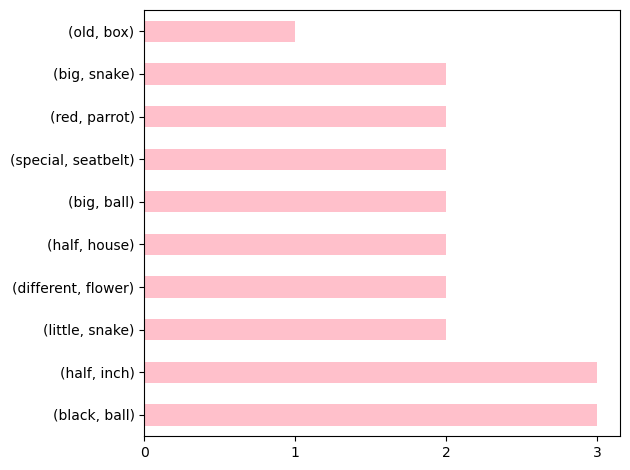

In [229]:
pair_list = []
for strings in df["Speech"]:
    cleaned_text = clean_text(strings)
    doc = nlp(cleaned_text)
    n_grams(doc, 4, pair_list)

bigrams = pd.Series(pair_list).value_counts()[:10]
bigrams.plot(kind="barh", color="pink")

max_count = bigrams.max()
plt.xticks(range(0, max_count + 1, 1))
plt.tight_layout()
plt.show()

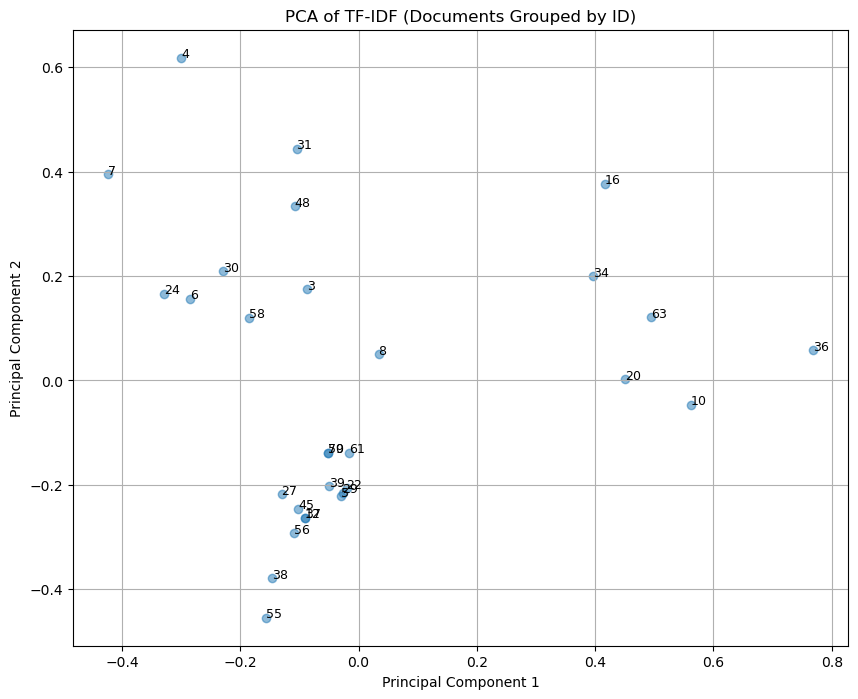

In [213]:
adj_perform_across_children(df, perform_clustering=False)

In [230]:
create_network_visualization(adj_dict, "food_adj_referent.html")

# Animal Referent

In [215]:
df = pd.read_csv(
    dir.parent
    / "Data"
    / "Master Children Description Data - Master animal description.csv",
    usecols=lambda column: column != "Order",
)

df.rename(columns={"ID": "Participant ID"}, inplace=True)
df["Participant ID"] = df["Participant ID"].astype(str)
# Clean the text and extract adjectives
df["Speech"] = df["Speech"].astype(str)
df["Speech"] = df["Speech"].apply(clean_text)
df["Adjectives_Spacy"] = df["Speech"].apply(extract_adjectives)

df.to_csv(dir.parent / "Result" / "animal_adj.csv")

In [231]:
def referent_animal_adj_parser(file_path):
    adj_dict = {}

    with open(file_path, "r") as file_obj:
        reader = csv.reader(file_obj)
        next(reader)  # Skip the header row

        for row in reader:
            if row[3] == "nan":
                referent = row[2].lower()
                referent = clean_referent(referent)
                adj_dict[referent] = adj_dict.get(referent, [])
            try:
                adjectives = ast.literal_eval(row[-1])
                if isinstance(adjectives, list):
                    adj_dict[referent].extend(adjectives)
                    for current_adj in adjectives:
                        if (
                            update_with_shorter_adjective(
                                adj_dict[referent], current_adj
                            )
                            is not None
                        ):
                            current_adj = update_with_shorter_adjective(
                                adj_dict[referent], current_adj
                            )
                        adj_dict[referent].append(current_adj)
            except (ValueError, SyntaxError):
                continue

    return adj_dict

In [242]:
file_path = dir.parent / "Result" / "animal_adj.csv"
adj_dict = referent_animal_adj_parser(file_path)

334


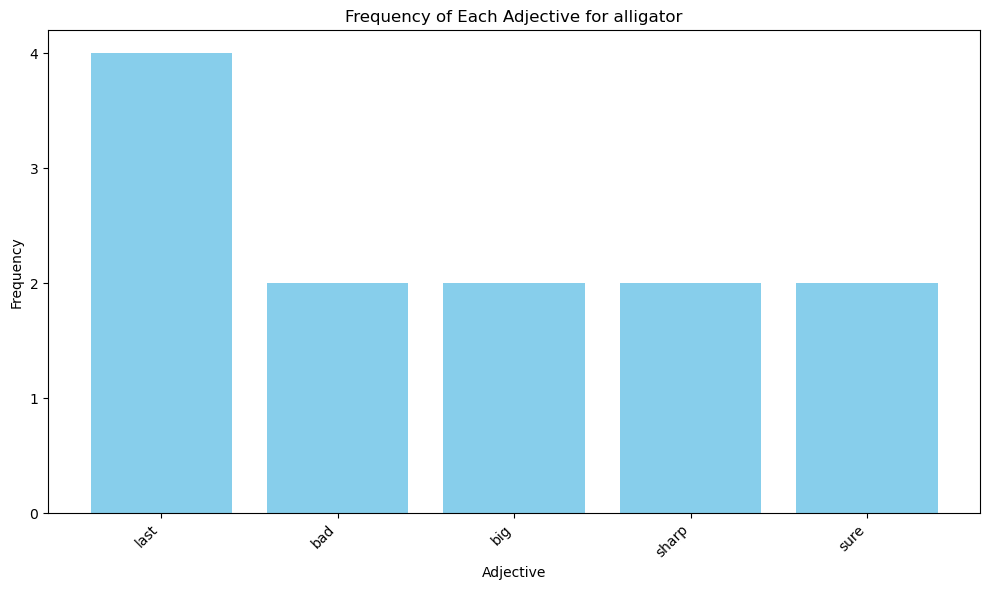

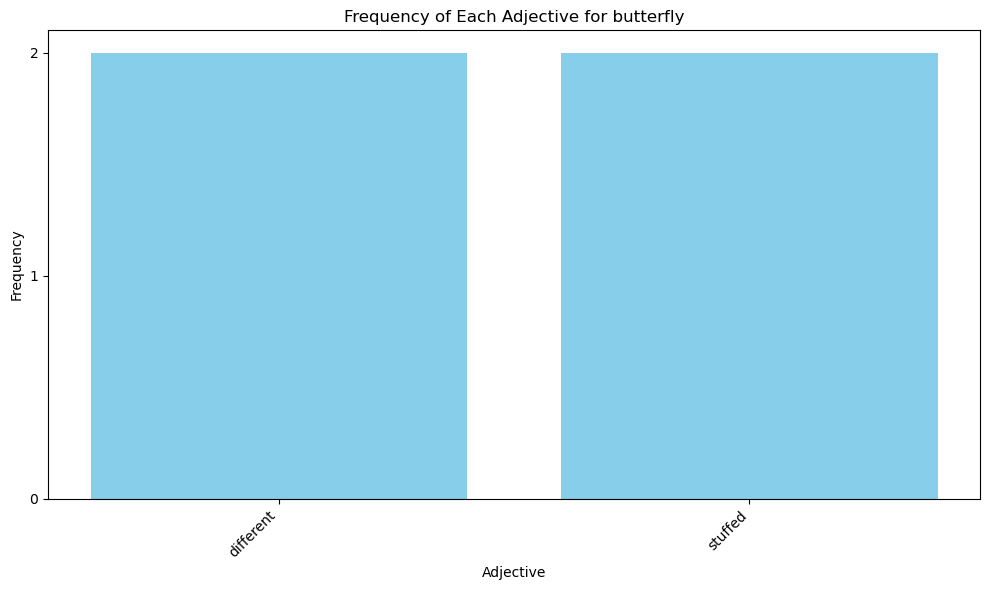

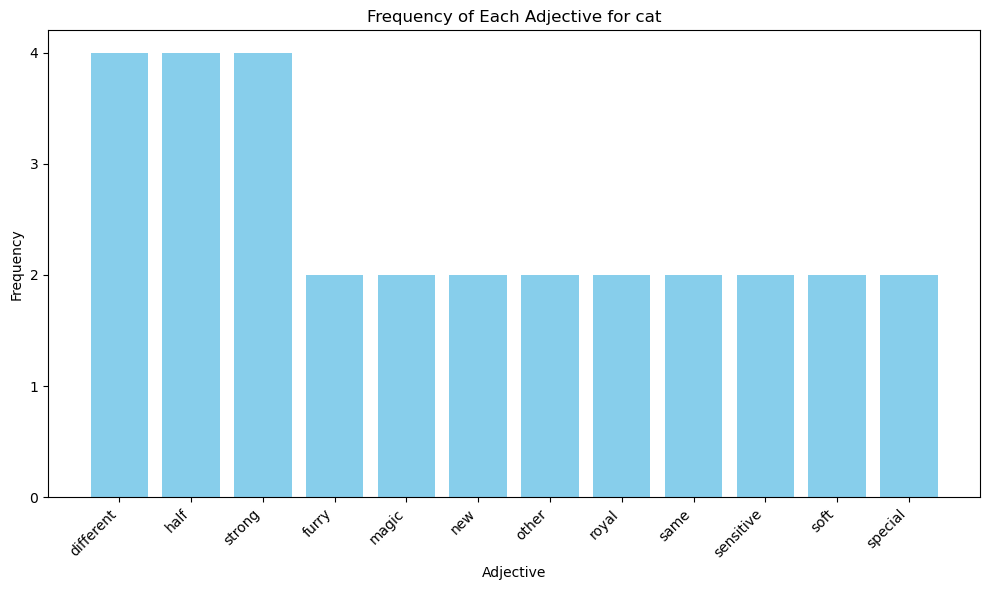

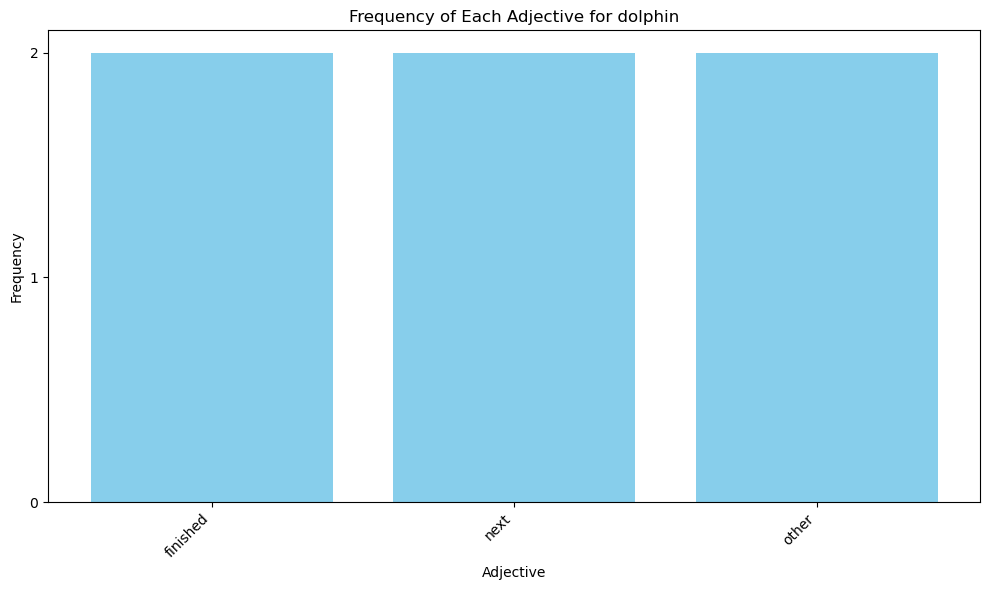

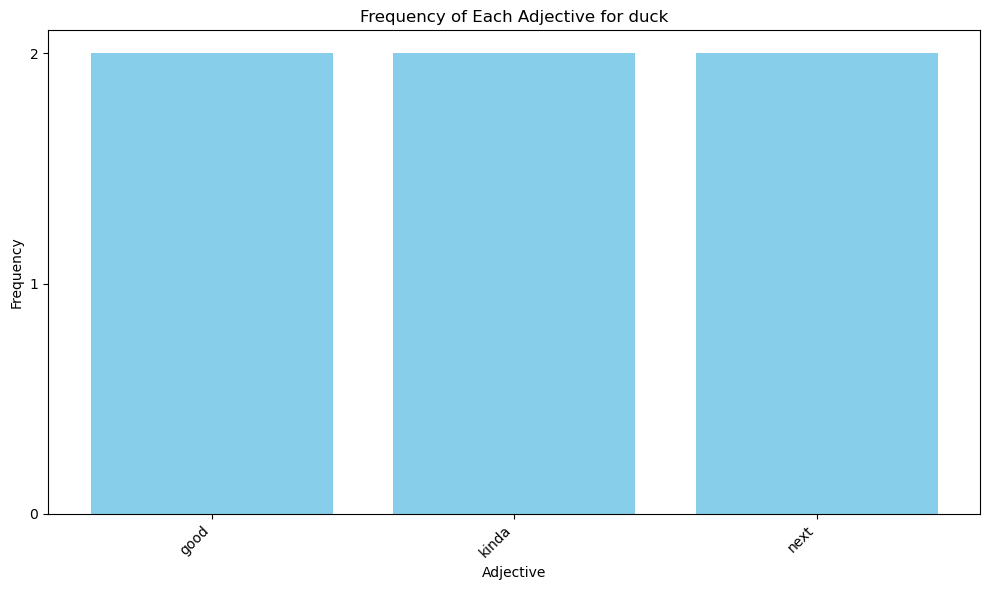

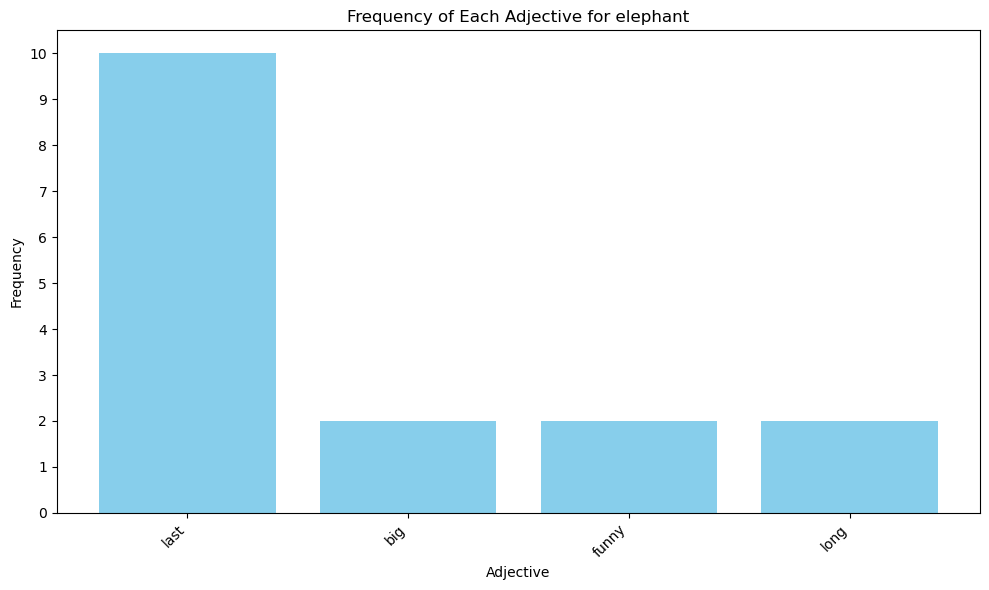

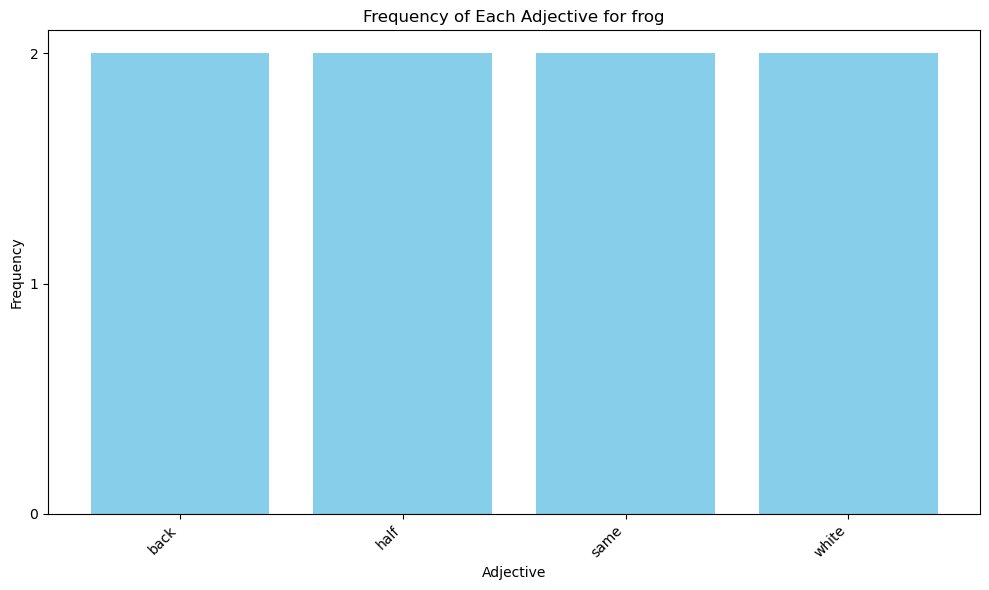

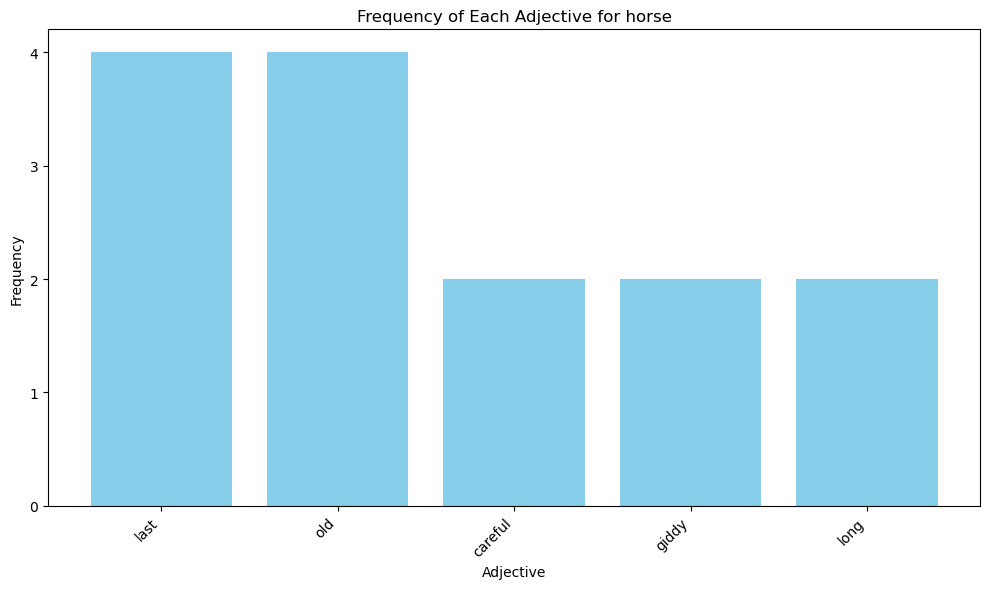

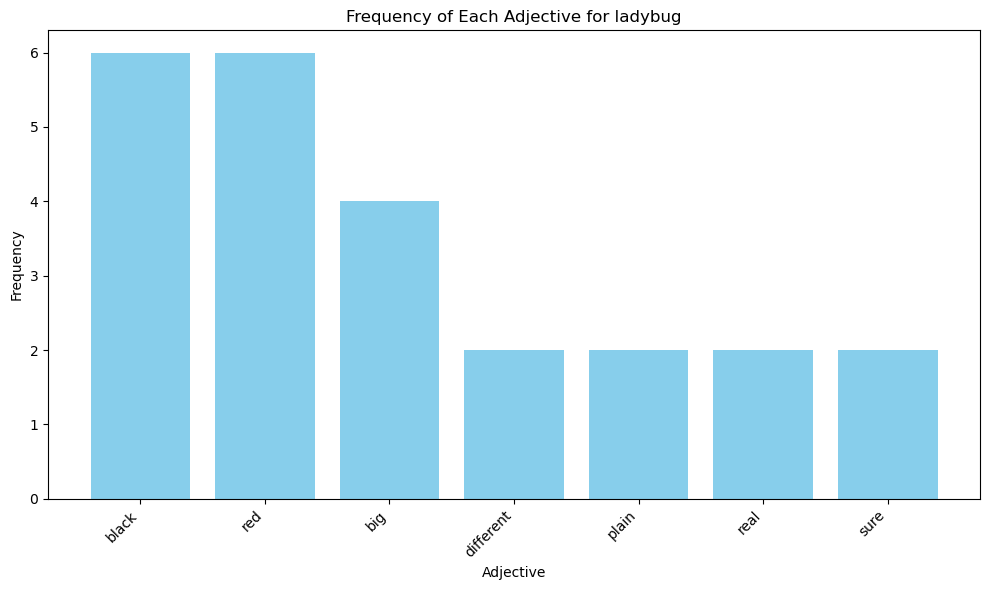

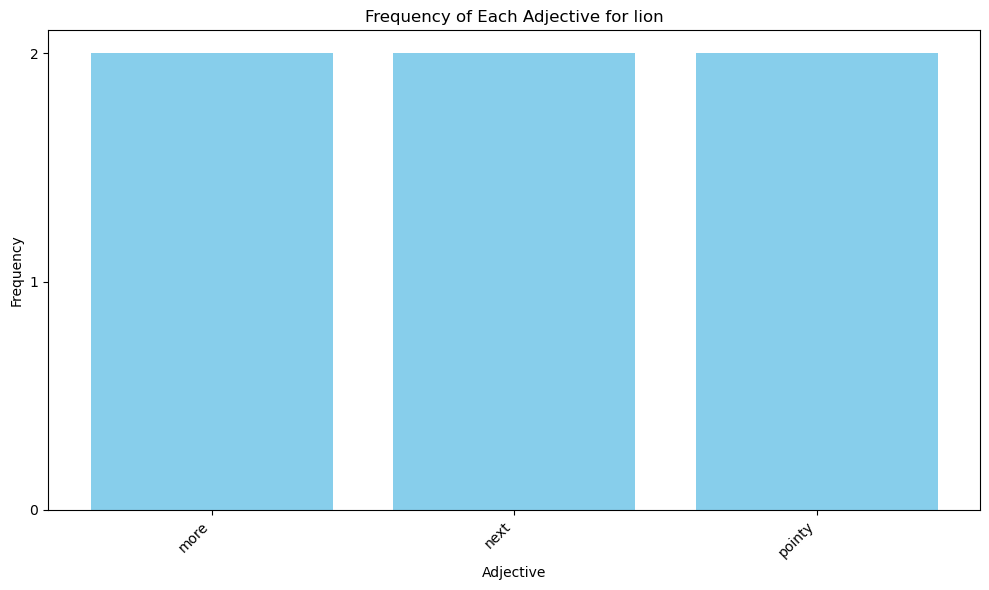

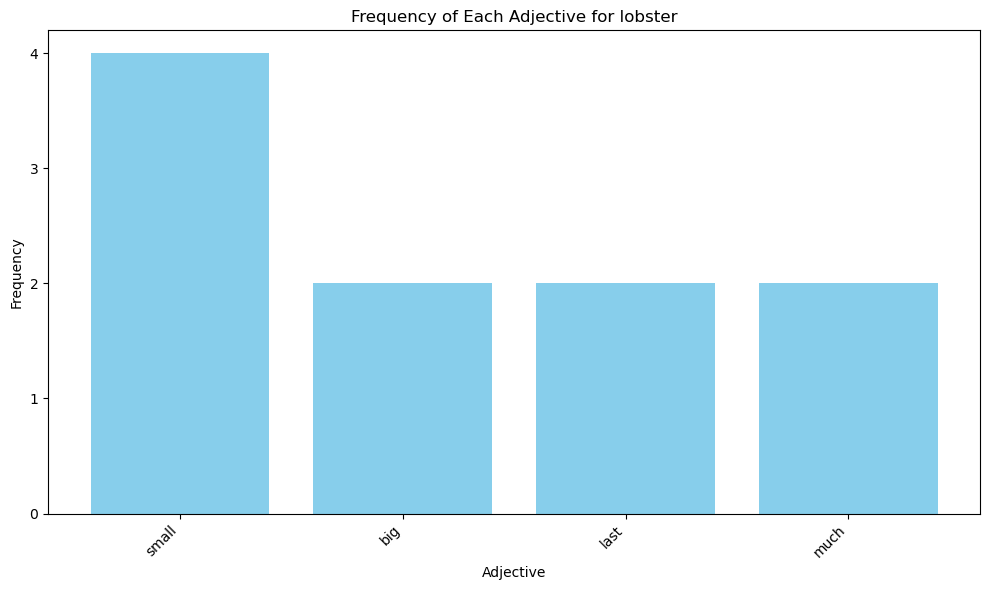

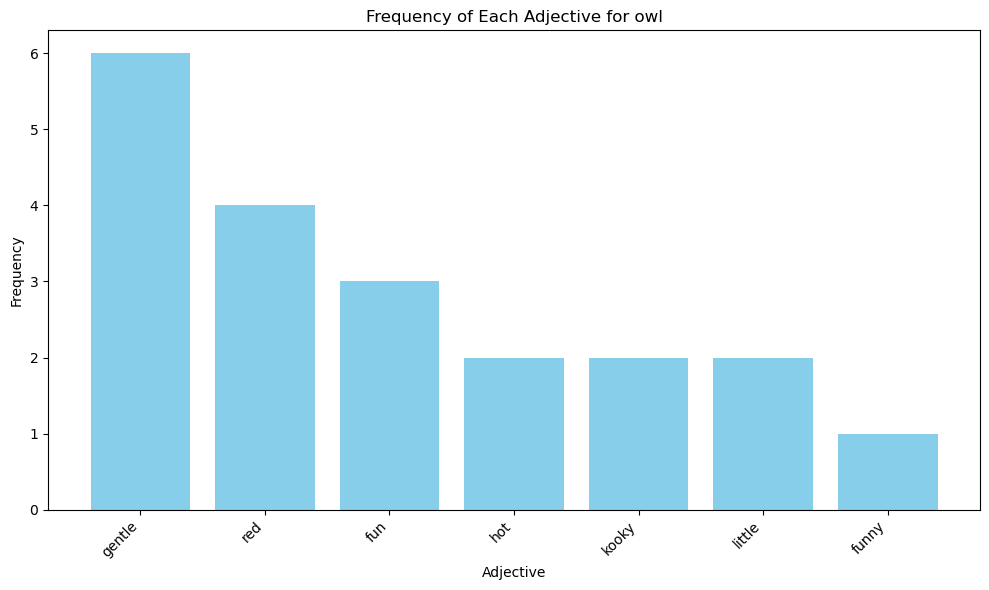

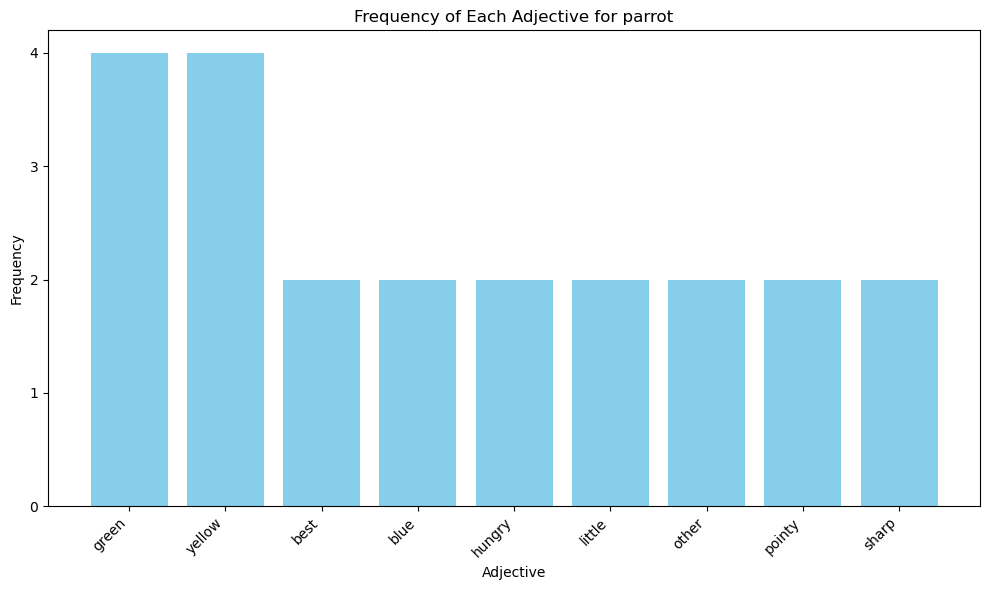

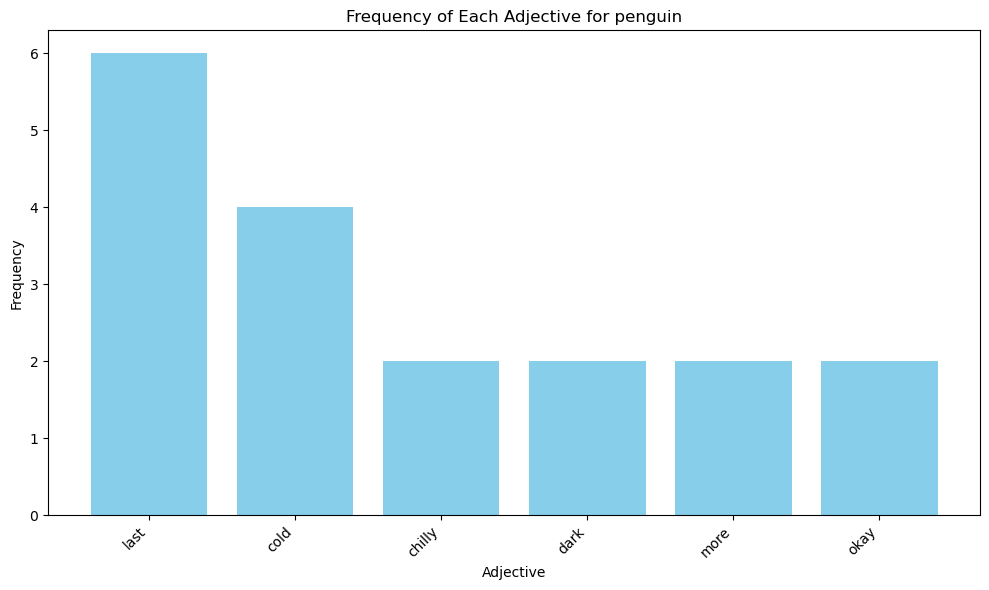

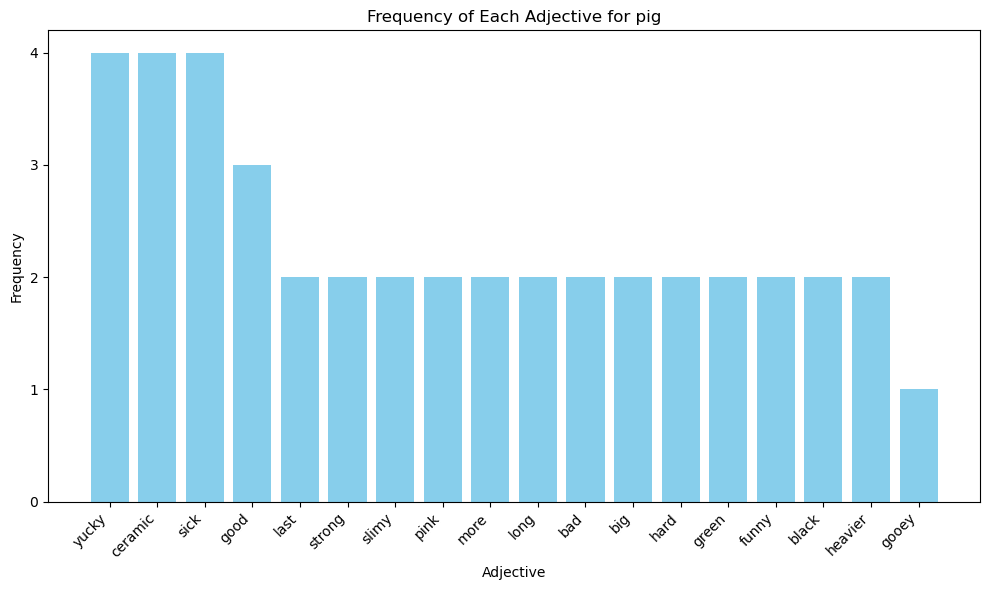

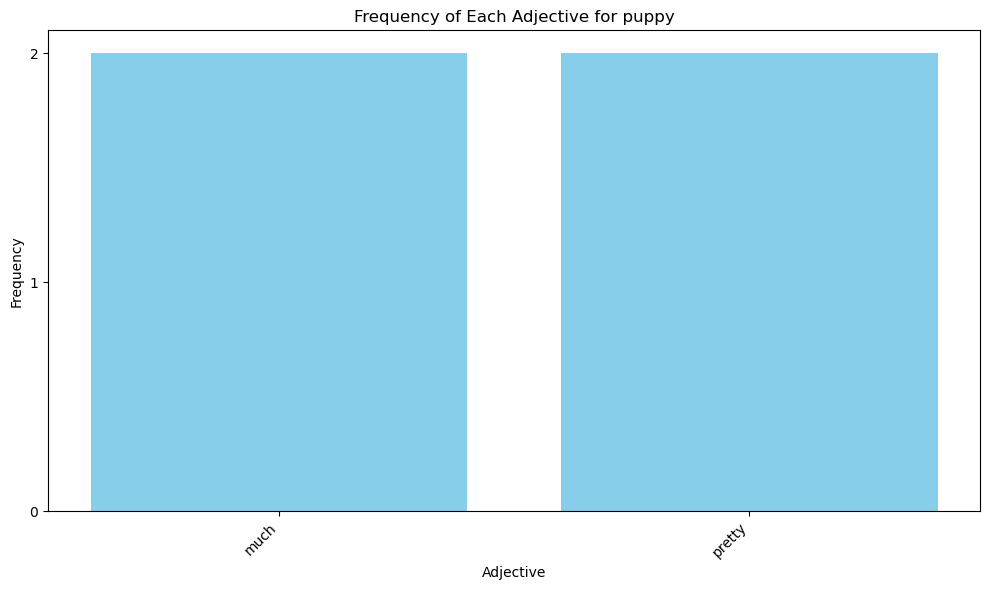

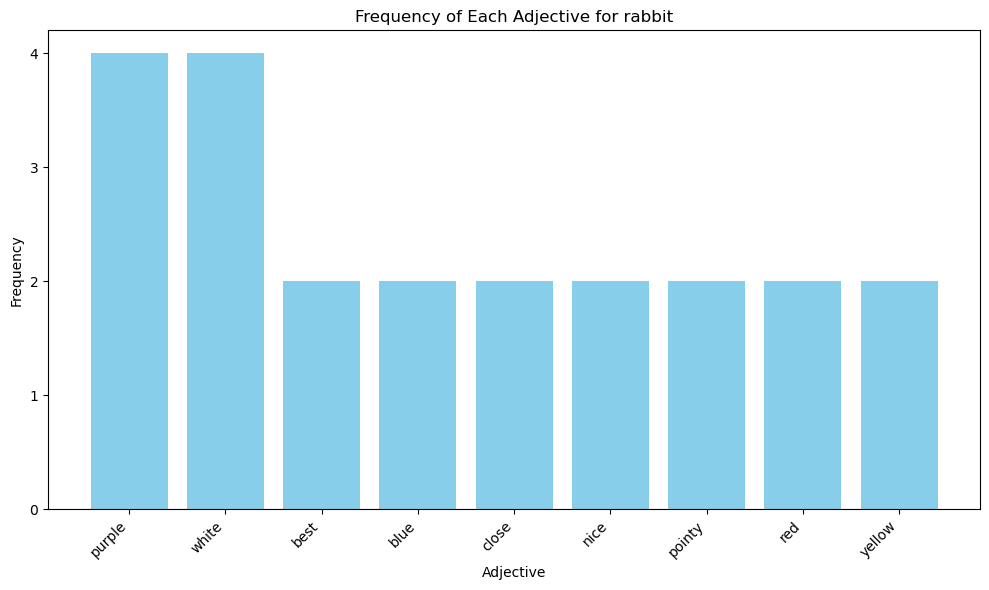

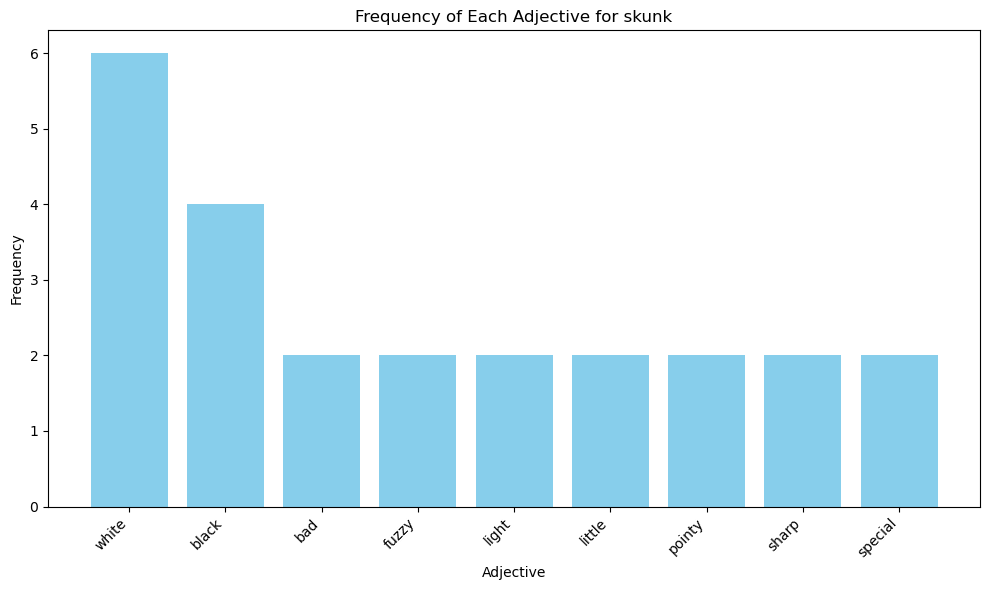

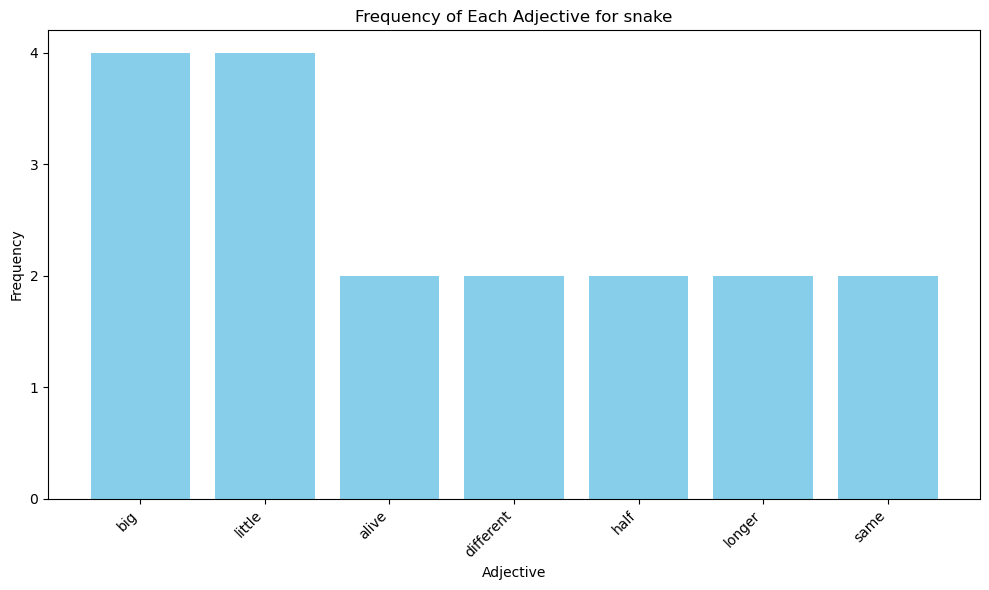

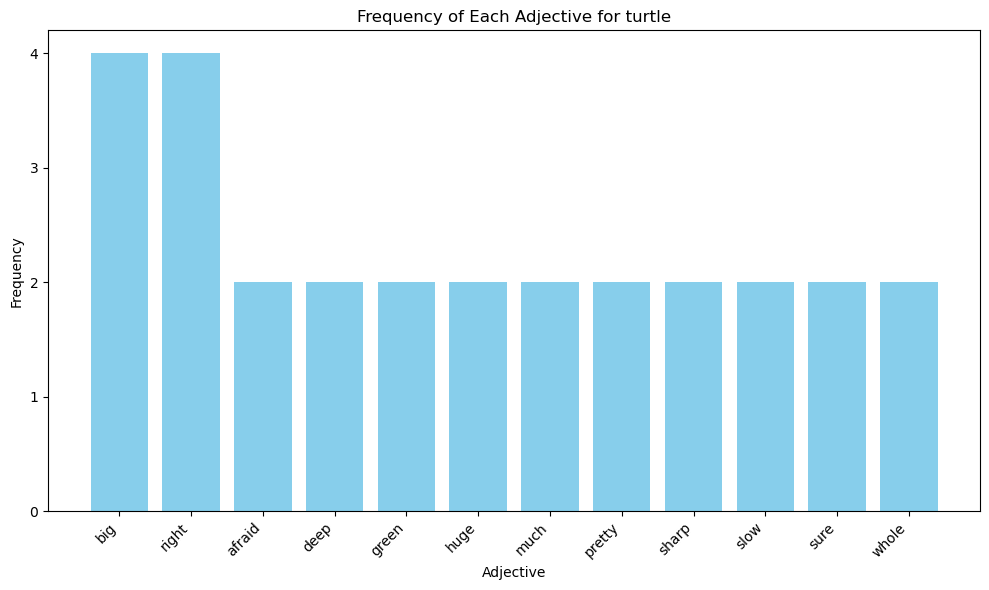

In [243]:
plot_adj_freq_by_referent(adj_dict)

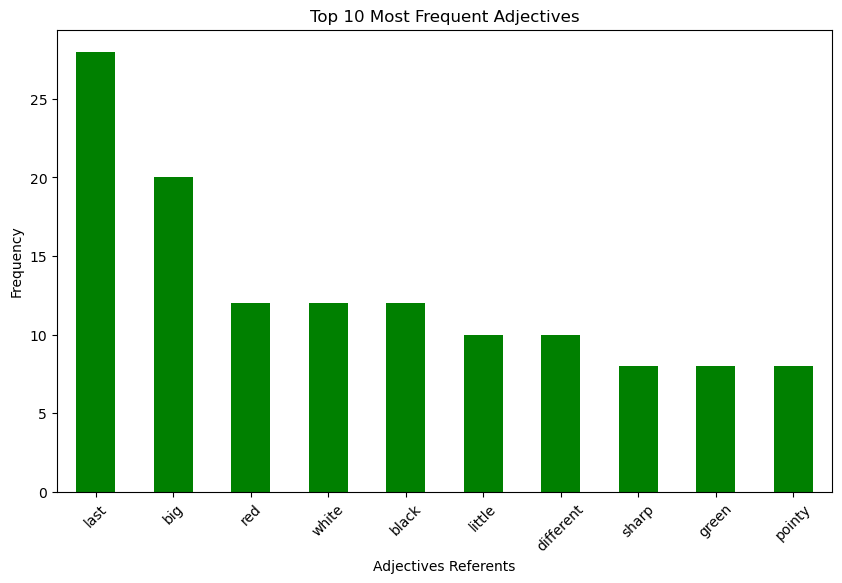

In [234]:
plot_top_adjectives(adj_dict)

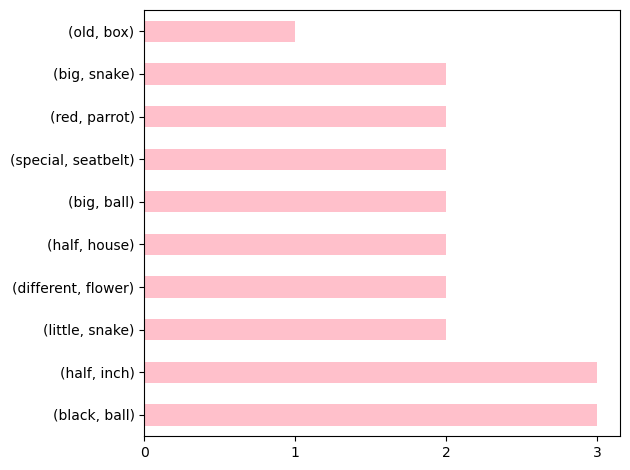

In [220]:
pair_list = []
for strings in df["Speech"]:
    cleaned_text = clean_text(strings)
    doc = nlp(cleaned_text)
    n_grams(doc, 4, pair_list)

bigrams = pd.Series(pair_list).value_counts()[:10]
bigrams.plot(kind="barh", color="pink")

max_count = bigrams.max()
plt.xticks(range(0, max_count + 1, 1))
plt.tight_layout()
plt.show()

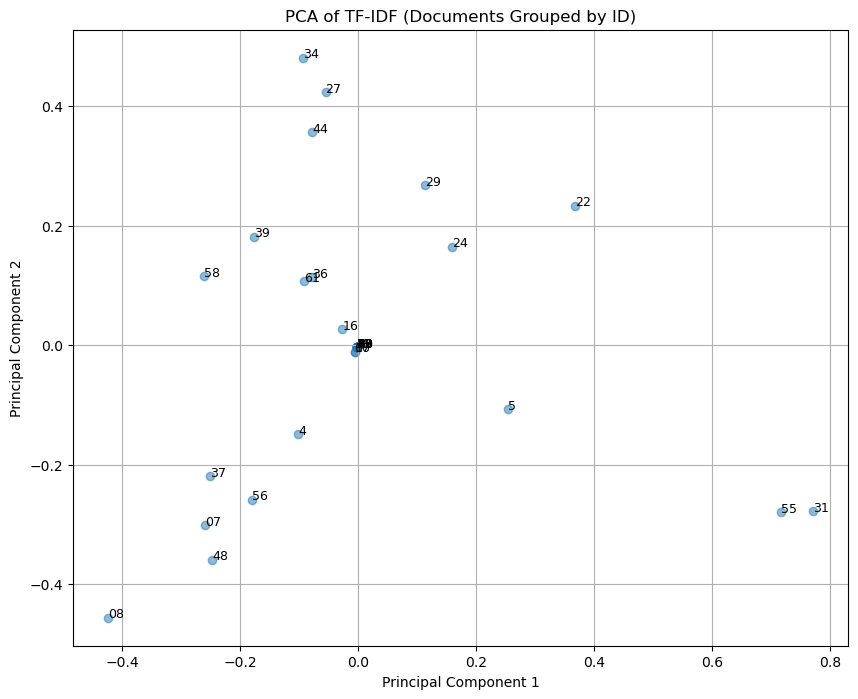

In [221]:
adj_perform_across_children(df, perform_clustering=False)

In [235]:
create_network_visualization(adj_dict, "animal_adj_referent.html")

In [ ]:
# Network with processed csv
"""
pairs = pd.read_csv("Adjective_referent_With_Weight_Food.csv")
# count the duplicate pairs of {adjective, referent} and assign this duplicate count as weight
pairs = pairs.groupby(by=["Adjective", "Referent"]).size().reset_index(name="duplicate")

os.chdir(dir.parent / "Result")
pairs.to_csv("WeightforNetwork_Food.csv")

# Prepare data for network
sources = pairs["Adjective"]
targets = pairs["Referent"]
weights = pairs["duplicate"]
edge_data = zip(sources, targets, weights)

# Initialize Pyvis Network
got_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

# Set the adjective node, referent node, and edge length
for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    got_net.add_node(src, src, title=src, color="pink")
    got_net.add_node(dst, dst, title=dst)
    got_net.add_edge(src, dst, value=w)

# Generate neighbor map
neighbor_map = got_net.get_adj_list()

# Add neighbor data to node hover data
for node in got_net.nodes:
    node["title"] += " Neighbors:" + " ".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

got_net.save_graph("food_adj_referent.html")
"""

In [ ]:
# Sample NLTK codes
# nltk.download('stopwords')
import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
df = pd.read_csv(
    dir.parent
    / "Data"
    / "Master Children Description Data - Master food description.csv"
)
text = df["Speech"].astype(str)
punctuation = re.compile(r"[-.?!,:;()'|0-9]")
stopWords = ["&", "xxx", "=", "_", "zorg", "mm-hm"]
text2 = []
noun_adj_pairs = []
adj = []

for strings in text:
    strings = strings.replace("CHI:", "")
    tokenized = wordpunct_tokenize(strings)
    wordsList = []
    for word in tokenized:
        word = punctuation.sub("", word)
        if word not in stopWords:
            if len(word) > 0:
                wordsList.append(word)
    # Use a Tagger. Which is part-of-speech
    # tagger or POS-tagger.
    tagged = nltk.pos_tag(wordsList)
    for i in tagged:
        if i[1] == "JJ" and i[0] not in stop_words:
            adj.append(i[0])
    if strings == "nan":
        adj.append("")

additional = pd.DataFrame({"Adjectives_NLTK": adj})
new = pd.concat([df, additional], axis=1)
new

,Order,ID,Speech,Feature,referent,Adjectives(NLTK predictions_seperated by blank line),Adjectives(Spacy predictions),Adjectives_NLTK
0,1.0,7.0,CHI: a cracker.,L,cracker,cracker,cracker,white
1,1.0,7.0,CHI: a cracker that's that's blue and a...,L+P,cracker,blue,blue,orange
2,1.0,7.0,CHI: it's a colors.,P,cracker,white,orange,white
3,1.0,7.0,CHI: it can eat.,F,cracker,orange,white,thirteen
4,1.0,7.0,CHI: it eats.,NaN,cracker,white,orange,light
...,...,...,...,...,...,...,...,...
859,27.0,31.0,"CHI: it's, healthy.",P,broccoli,NaN,NaN,NaN
860,27.0,31.0,CHI: it is yummy.,I+P,broccoli,NaN,NaN,NaN
861,27.0,31.0,"CHI: and I know one more, which I don't...",I,broccoli,NaN,NaN,NaN
862,27.0,31.0,CHI: it has Vitamin_C.,P,broccoli,NaN,NaN,NaN


<Axes: ylabel='Adjectives_NLTK'>

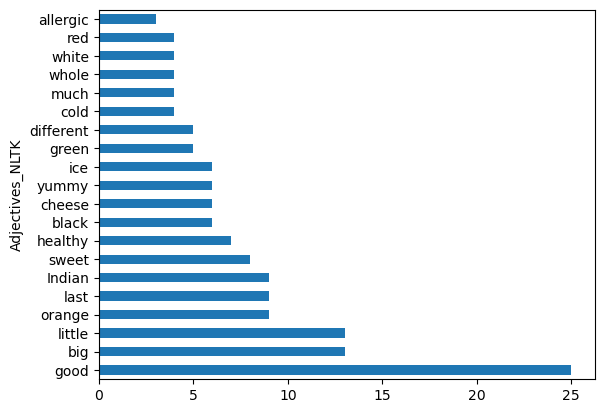

In [ ]:
cleaned_adj = new[new["Adjectives_NLTK"].str.len() > 0]
# creating the bar plot
cleaned_adj["Adjectives_NLTK"].value_counts()[:20].plot(kind="barh")

In [ ]:
# NLTK reliability check
df = pd.read_csv(dir.parent / "Data" / "Sample1.csv")
stop_words = set(stopwords.words("english"))
stopWords = ["&", "xxx", "=", "_", "zorg", "mm-hm", "[", "]", "um"]
text = df["Transcript"].astype(str)
text2 = []
noun_adj_pairs = []
noun = []
pronoun = []
m = 0
n = 0
noun_pre = df["Noun (1/0)"]
pronoun_pre = df["Pronoun (1/0)"]
for strings in text:
    for badWord in stopWords:
        strings = strings.replace(badWord, "")
    tokenized = wordpunct_tokenize(strings)
    tagged = nltk.pos_tag(tokenized)
    count1 = 0
    count2 = 0
    for i in tagged:
        if (i[1] == "NN" or i[1] == "NNP" or i[1] == "NNPS" or i[1] == "NNS") and i[
            0
        ] not in stop_words:
            count1 += 1

        if i[1] == "PRP" or i[1] == "PRP$":
            count2 += 1
    noun.append(count1)
    pronoun.append(count2)

additional = pd.DataFrame({"Nouns_NLTK": noun, "Pronoun_NLTK": pronoun})
additional.to_csv(dir.parent / "Result" / "Sample1_NLTK.csv")

# Accuracy Check
for i in range(len(noun)):
    if noun[i] == noun_pre[i]:
        m += 1
    if pronoun[i] == pronoun_pre[i]:
        n += 1

accuracy_noun_NLTK = m / len(noun)
accuracy_pronoun_NLTK = n / len(pronoun)
print(accuracy_noun_NLTK)
print(accuracy_pronoun_NLTK)

0.5148975791433892
0.8798882681564246
